<h1><center>Определение стоимости автомобилей</center></h1>

<font size="4"><b>Описание исследования</b></font>

Заказчиком в данном проекте является оператор связи «ТелеДом», который предоставляет два основных типа услуг: Стационарную телефонную связь и интернет. Также доступны дополнительные услуги.
Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.


<font size="4"><b>Цель проекта</b></font>

Заказчик хочет бороться с оттоком клиентов. С помощью машинного обучения необходимо наилучшим образом предсказывать разорвёт ли абонент договор.

<font size="4"><b>Задачи исследования</b></font>

Разработать модель машинного обучения для предсказания ухода клиента.


<font size="4"><b>Исходные данные</b></font>

В наличии 4 csv-файла с данными:
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

Название и описание столбцов:

Файл `contract_new.csv`:

- customerID — идентификатор абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

Файл `personal_new.csv`:

- customerID — идентификатор пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

Файл internet_new.csv

- customerID — идентификатор пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

Файл phone_new.csv

- customerID — идентификатор пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

### Загрузка данных и их предварительный просмотр

In [1]:
!pip install phik -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 4.5 MB/s eta 0:00:00


In [2]:
!pip install snakecase -q

  Preparing metadata (setup.py) ... done


In [3]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 2.0 MB/s eta 0:00:00


In [4]:
!pip install shap -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 4.2 MB/s eta 0:00:00


In [5]:
# импорт библиотек
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import re
import shap
from datetime import datetime
import sklearn
import os
import snakecase

# загружаем необходимые инструменты
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from phik.report import plot_correlation_matrix
from phik import phik_matrix

# загружаем классы для преобразования данных
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler
)

# загружаем инструмент для автоподбора гиперпараметров
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем нужные метрики
from sklearn import metrics
from sklearn.metrics import (
    roc_auc_score, accuracy_score, confusion_matrix,
    RocCurveDisplay, DetCurveDisplay
    )

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier, Pool, cv
from sklearn.dummy import DummyClassifier
from catboost.utils import get_roc_curve

In [7]:
# улучшение чёткости изображения
%config InlineBackend.figure_format = 'retina'

# настройка шрифтов заголовков и подписей для графиков
large = 16; med = 14; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large,
          'figure.titleweight': 'bold'}
plt.rcParams.update(params)
plt.style.use('seaborn-bright')

In [8]:
# задание константных значений
RANDOM_STATE = 180324
TEST_SIZE = 0.25

Для начала последовательно считаем исходные csv-файлы и сохраним их в отдельных переменных. Затем сделаем предварительный просмотр данных методом sample(10) и с помощью метода info() узнаем основные характеристики исходных датасетов.

In [10]:
def import_and_review(file_name):
  pth1 = '/datasets/'+file_name
  pth2 = '/content/drive/MyDrive/datasets/'+file_name
  pth3 = 'https://code.s3.yandex.net/datasets/'

  if os.path.exists(pth1):
      df = pd.read_csv(pth1)
  elif os.path.exists(pth2):
      df = pd.read_csv(pth2)
  elif os.path.exists(pth3):
      df = pd.read_csv(pth3)
  else:
      print('Something is wrong')

  display(df.sample(10))
  print('='*120)
  display(df.info())

  return df

In [11]:
# сохранение данных в переменной contract и их предварительный просмотр
contract = import_and_review('contract_new.csv')

customerID   BeginDate     EndDate            Type PaperlessBilling  \
5508  6010-DDPPW  2014-04-01          No        Two year               No   
3271  3902-FOIGH  2019-01-01          No  Month-to-month              Yes   
6009  6646-VRFOL  2015-05-01  2017-04-01  Month-to-month              Yes   
1441  2480-EJWYP  2015-04-01  2017-05-01        One year              Yes   
28    5248-YGIJN  2014-02-01          No        Two year              Yes   
2799  7009-PCARS  2015-07-01          No        One year               No   
3900  8008-OTEZX  2017-03-01          No        One year               No   
3839  8387-UGUSU  2018-11-01          No  Month-to-month               No   
3213  4032-RMHCI  2016-09-01          No        One year               No   
3967  5914-GXMDA  2017-06-01          No        One year               No   

                  PaymentMethod  MonthlyCharges TotalCharges  
5508  Bank transfer (automatic)           25.15       1760.5  
3271           Electronic check          101.35       1343.9  
6009           Electronic check          103.85      2388.55  
1441  Bank transfer (automatic)           97.80      2567.25  
28      Credit card (automatic)           90.25       6498.0  
2799  Bank transfer (automatic)           19.10       1050.5  
3900               Mailed check           19.65       687.75  
3839               Mailed check           20.05       300.75  
3213    Credit card (automatic)           35.40      1523.97  
3967               Mailed check           19.30        617.6

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

In [12]:
# сохранение данных в переменной personnal и их предварительный просмотр
personal = import_and_review('personal_new.csv')

customerID  gender  SeniorCitizen Partner Dependents
2922  3348-CFRNX  Female              0     Yes         No
1736  7551-JOHTI  Female              0      No         No
503   7803-XOCCZ  Female              0     Yes        Yes
588   0742-LAFQK    Male              0     Yes         No
2904  2115-BFTIW    Male              0      No         No
6173  2378-HTWFW    Male              1      No         No
4258  9360-AHGNL  Female              1     Yes         No
6785  3090-HAWSU    Male              0      No         No
1477  5469-CTCWN    Male              0     Yes        Yes
4403  0257-KXZGU  Female              0     Yes        Yes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

In [13]:
internet = import_and_review('internet_new.csv')

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
1382  4137-JOPHL     Fiber optic             No           No              Yes   
2096  8166-ORCHU     Fiber optic            Yes          Yes               No   
1764  0866-QLSIR             DSL            Yes          Yes               No   
5453  7240-FQLHE     Fiber optic             No           No               No   
3588  3440-JPSCL     Fiber optic             No           No              Yes   
232   3488-PGMQJ     Fiber optic             No          Yes               No   
3084  8720-RQSBJ             DSL             No           No               No   
696   1937-OTUKY     Fiber optic            Yes           No              Yes   
4945  7798-JVXYM             DSL             No           No               No   
438   5394-MEITZ             DSL             No          Yes              Yes   

     TechSupport StreamingTV StreamingMovies  
1382         Yes          No             Yes  
2096         Yes          No             Yes  
1764         Yes          No              No  
5453         Yes         Yes             Yes  
3588         Yes         Yes             Yes  
232           No          No              No  
3084          No          No              No  
696          Yes         Yes              No  
4945         Yes         Yes             Yes  
438          Yes         Yes             Yes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

In [14]:
phone = import_and_review('phone_new.csv')

customerID MultipleLines
4205  4480-QQRHC            No
5702  7356-IWLFW           Yes
2866  9099-FTUHS           Yes
2293  7016-NVRIC            No
1343  6048-UWKAL           Yes
5693  3422-GALYP           Yes
2962  6818-DJXAA            No
0     5575-GNVDE            No
598   8095-WANWK            No
5816  0480-KYJVA           Yes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

<font size="4"><b>Выводы по первоначальному обзору данных всех исходных датафреймов</b></font>

- Названия столбцов написаны "верблюжьим" регистром. Нужно привести его в "змеиный".
- Проверить все столбцы со строковым типом данных на неявные дубликаты и всю таблицу на явные.
- Пропусков нет ни в одном из датафреймов.
- Необходимо поменять тип данных в столбце `TotalCharges` датафрейма `contract` с object на float. Также заменить тип с object на datetime в столбцах `BeginDate` и `EndDate`.
- Данные в столбце `SeniorCitizen` заменить на строковый тип по аналогии с другими столбцами на "Yes" и "No".
- Количество строк в датафреймах одинаковое - 7043. Возможно это данные по одним и тем же клиентам. Это нужно проверить.
- В датафреймах `internet` и `phone` меньше строк: 5517 и 6361 соответственно. Значит не все клиенты этого провайдера пользуются услугами интернета и телефонии.
- При объединении всех 4 датафреймов появятся пропуски.
- Целевой признак уйдет клиент или нет нужно создать из столбца `EndDate`. Всем клиентам, у которых в этом столбце стоит "No" присвоить класс "0", т.е. действующий абонент, а тем у кого стоит дата, присвоить класс "1", т.е. расторгнул договор.
- Заменить "No" в столбце `EndDate` на дату скачивания базы данных - 2020-02-01 и рассчитать дополнительный признак длительность подписки.

Проверим повторяются ли данные по одним и тем же клиентам в датафреймах. Для этого посчитаем количество уникальных `customerID` во всех датафреймах.

In [15]:
# цикл для подсчета уникальных значений id для каждого датафрейма
for data, title in zip((contract, personal, internet, phone), \
 ('contract', 'personal', 'internet', 'phone')):

    print(f'Количество уникальных id в датафрейме {title}: \
    {data["customerID"].nunique()} \n')

Количество уникальных id в датафрейме contract: 7043 

Количество уникальных id в датафрейме personal: 7043 

Количество уникальных id в датафрейме internet: 5517 

Количество уникальных id в датафрейме phone: 6361 



Повторов по клиентам нет. В каждой строчке каждого датафрейма данные по разным пользователям. Проверим теперь совпадают ли `customerID` в датафреймах contract и personal.

In [16]:
print('id, которые есть в датафрейме contract, но нет в personal\n', \
      contract['customerID'][~contract['customerID'].isin(personal['customerID'])
      ]
      )

id, которые есть в датафрейме contract, но нет в personal
 Series([], Name: customerID, dtype: object)


Персональные данные есть по всем клиентам, заключившим договор. Проверим есть ли в датафреймах internet и phone данных по клиентам, которых нет в contract.

In [17]:
print('id, которые есть в датафрейме internet, но нет в contract\n', \
      internet['customerID'][~internet['customerID'].isin(contract['customerID'])
      ]
      )

print('id, которые есть в датафрейме phone, но нет в contract\n', \
      phone['customerID'][~phone['customerID'].isin(contract['customerID'])
      ]
      )

id, которые есть в датафрейме internet, но нет в contract
 Series([], Name: customerID, dtype: object)
id, которые есть в датафрейме phone, но нет в contract
 Series([], Name: customerID, dtype: object)


Получили пустые объекты Series, значит по всем клиентам этого провайдера имеется информация о заключенном договоре и персональных данных. Теперь можно убрать `customerID` в индекс и перейти к следующему шагу.

In [18]:
# установка столбца 'customerID' в качестве индекса для всех датафреймов
for data in (contract, personal, internet, phone):
    data.set_index('customerID', inplace=True)

Сохраним изначальную размерность всех датафреймов, для того чтобы после всех преобразований проверить, что всё прошло корректно и ничего лишнего не добавлено и не удалено.
Для каждой таблицы сохраним количество строк и столбцов. Для этого воспользуемся методом shape. Причём первый элемент [0] содержит в себе количество строк, а второй [1] - количество столбцов.

In [19]:
# сохранение количества строк и столбцов для датафрейма contract
rows_initial_contract = contract.shape[0]
columns_initial_contract = contract.shape[1]
# сохранение количества строк и столбцов для датафрейма personal
rows_initial_personal = personal.shape[0]
columns_initial_personal = personal.shape[1]
# сохранение количества строк и столбцов для датафрейма internet
rows_initial_internet = internet.shape[0]
columns_initial_internet = internet.shape[1]
# сохранение количества строк и столбцов для датафрейма phone
rows_initial_phone = phone.shape[0]
columns_initial_phone = phone.shape[1]

На основе данных столбца `EndDate` создадим целевой бинарный признак `quit`. Если стоит "No", то присвоим класс "0", т.е. действующий клиент, если дата, то "1", т.е. расторгнувший договор.
Кроме того, заменим "No" в этом столбце на дату скачивания базы данных - 2020-02-01.

In [20]:
# создание целевого признака 'quit', т.е. ушел клиент или нет
contract['quit'] = 0
contract['quit'] = contract['quit'].where(contract['EndDate'] == 'No', 1)
# замена значения 'No' на актуальную дату
contract.loc[contract['EndDate'] == 'No', 'EndDate'] = '2020-02-01'

## Объединение данных

Объединим все датафрейма с помощью метода join(), который позволяет объединить сразу несколько датафреймов по индексу. Укажем параметр how='outer', чтобы включить все имеющиеся данные.

In [21]:
# создание объединённого датафрейма combined и просмотр его 5 случайных строчек
combined = contract.join([personal, internet, phone], how='outer')
combined.sample(5)

BeginDate     EndDate            Type PaperlessBilling  \
customerID                                                            
9788-YTFGE  2019-07-01  2020-02-01  Month-to-month              Yes   
2055-PDADH  2019-09-01  2020-02-01  Month-to-month              Yes   
5944-UGLLK  2015-09-01  2020-02-01        One year               No   
2578-JQPHZ  2016-06-01  2020-02-01        Two year               No   
8173-RXAYP  2018-02-01  2020-02-01        Two year               No   

                        PaymentMethod  MonthlyCharges TotalCharges  quit  \
customerID                                                                 
9788-YTFGE               Mailed check           19.95       139.65     0   
2055-PDADH           Electronic check           70.40       362.56     0   
5944-UGLLK    Credit card (automatic)           54.90       2909.7     0   
2578-JQPHZ  Bank transfer (automatic)          100.10      4448.44     0   
8173-RXAYP               Mailed check           19.70       477.53     0   

            gender  SeniorCitizen Partner Dependents InternetService  \
customerID                                                             
9788-YTFGE    Male              0      No         No             NaN   
2055-PDADH  Female              1      No         No     Fiber optic   
5944-UGLLK    Male              0      No         No             DSL   
2578-JQPHZ    Male              0      No         No     Fiber optic   
8173-RXAYP  Female              0     Yes        Yes             NaN   

           OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
customerID                                                            
9788-YTFGE            NaN          NaN              NaN         NaN   
2055-PDADH             No           No               No          No   
5944-UGLLK             No           No              Yes         Yes   
2578-JQPHZ             No           No              Yes         Yes   
8173-RXAYP            NaN          NaN              NaN         NaN   

           StreamingTV StreamingMovies MultipleLines  
customerID                                            
9788-YTFGE         NaN             NaN            No  
2055-PDADH          No              No            No  
5944-UGLLK         Yes             Yes           NaN  
2578-JQPHZ         Yes             Yes            No  
8173-RXAYP         NaN             NaN            No

##  Предобработка данных

Этап предобработки данных необходим для подготовки данных для их более корректого анализа.
Он включает в себя следующие пункты, которые проводятся при необходимости:
- обработка пропусков;
- переименование названий столбцов;
- преобразование типов данных;
- обработка дубликатов.



### Обработка пропусков

После объединения появились пропуски. Посмотрим на их долю и решим, что с ними делать.

In [22]:
# проверка доли пропусков на копии датафрейма
temp = combined.copy()
display(
    pd.DataFrame(
        round(
            (temp.isna().mean()*100), 2), columns=['NaNs, %'])
        .style.format( '{:.2f}')
        .background_gradient('coolwarm')
        )

В объединенном датафрейме появилось по 21.67% пропусков в 7 столбцах и 9.68% в одном столбце. Значит 21.68% всех клиентов не пользуются услугами интернета, а 9.68% - услугами телефонии. Доля пропусков значительна, поэтому их удалить нельзя. Чтобы не путать с имеющимися значениями "No" в этих столбцах, поставим на них "заглушку", т.е. заполним значением "Not used".

Воспользуемся методом fillna(). Т.к. будем заполнять все пропущенные значения во всем датафрейме одним значением, то список столбцов можно не указывать.

In [23]:
# заполнение пропусков во всем датафрейме значением 'Not used'
combined.fillna(value='Not used', inplace=True)

In [24]:
# проверим, что пропусков не осталось
temp = combined.copy()
display(
    pd.DataFrame(
        round(
            (temp.isna().mean()*100), 2), columns=['NaNs, %'])
        .style.format( '{:.2f}')
        .background_gradient('coolwarm')
        )

Название столбцов нужно привести к "змеиному" регистру.

### Переименование названий столбцов

Преобразуем названия столбцов из "верблюжьего" регистра в "змеиный" с помощью Snakecase Coverter и метода map(), который переименует последовательно каждый элемент списка названий столбцов.

In [25]:
# приведение названий столбцов к нижнему регистру и просмотр результата
combined.columns = map(snakecase.convert, combined.columns)
combined.columns

Index(['begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'quit', 'gender', 'senior_citizen',
       'partner', 'dependents', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'multiple_lines'],
      dtype='object')

Проверим наличие неявных и явных дубликатов.

### Обработка дубликатов

Проверим наличие дубликатов в столбцах с категориальными признаками с помощью метода unique(), который выдает список всех уникальных значений в столбце.

In [26]:
# цикл для просмотра уникальных значений в каждом столбце
for col in combined.columns:
    print(f'Столбец {col}: {combined[col].sort_values().unique()}\n')

Столбец begin_date: ['2013-10-01' '2013-11-01' '2013-12-01' '2014-01-01' '2014-02-01'
 '2014-03-01' '2014-04-01' '2014-05-01' '2014-06-01' '2014-07-01'
 '2014-08-01' '2014-09-01' '2014-10-01' '2014-11-01' '2014-12-01'
 '2015-01-01' '2015-02-01' '2015-03-01' '2015-04-01' '2015-05-01'
 '2015-06-01' '2015-07-01' '2015-08-01' '2015-09-01' '2015-10-01'
 '2015-11-01' '2015-12-01' '2016-01-01' '2016-02-01' '2016-03-01'
 '2016-04-01' '2016-05-01' '2016-06-01' '2016-07-01' '2016-08-01'
 '2016-09-01' '2016-10-01' '2016-11-01' '2016-12-01' '2017-01-01'
 '2017-02-01' '2017-03-01' '2017-04-01' '2017-05-01' '2017-06-01'
 '2017-07-01' '2017-08-01' '2017-09-01' '2017-10-01' '2017-11-01'
 '2017-12-01' '2018-01-01' '2018-02-01' '2018-03-01' '2018-04-01'
 '2018-05-01' '2018-06-01' '2018-07-01' '2018-08-01' '2018-09-01'
 '2018-10-01' '2018-11-01' '2018-12-01' '2019-01-01' '2019-02-01'
 '2019-03-01' '2019-04-01' '2019-05-01' '2019-06-01' '2019-07-01'
 '2019-08-01' '2019-09-01' '2019-10-01' '2019-11-01' '20

Неявных дубликатов нет. Есть пробелы (' ') в столбце `total_charges`. Проверим какую долю они составляют.

In [27]:
print('Доля пустых ячеек в столбце total_charges равна ', \
      round(len(combined.query('total_charges == " "')) * 100 / len(combined['total_charges']), 2), '%')

print('Их количество ', \
      round(
    len(
        combined.query('total_charges == " "')
        )
            ), 'строчек')

Доля пустых ячеек в столбце total_charges равна  0.16 %
Их количество  11 строчек


Пустых ячеек не так много: всего 0.16% от общего объема данных в столбце `total_charges`, поэтому их можно удалить.

In [28]:
# удаление пустых ячеек в столбце total_charges
combined = combined.query('total_charges != " "')

In [29]:
# замена "0" и "1" в столбце senior_citizen на "No" и "Yes"
combined['senior_citizen'] = combined['senior_citizen'].apply(lambda x: 'No' if x == 0 else 'Yes')

<ipython-input-29-ddc93a0c8786>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined['senior_citizen'] = combined['senior_citizen'].apply(lambda x: 'No' if x == 0 else 'Yes')




Проверим есть ли явные дубликаты в датафреймах.

In [30]:
# проверка явных дубликатов
combined.duplicated().sum()

4

In [31]:
# удалениe явных дубликатов
combined.drop_duplicates(inplace=True)

# проверка удаления явных дубликатов
combined.duplicated().sum()

<ipython-input-31-ab5281eb2537>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined.drop_duplicates(inplace=True)


0

После объединения всех исходных датафреймов, удаления дублирующихся и пустых строчек, необходимо сделать проверку размерности результирующей таблицы для того, чтобы убедиться в ее правильности, т.к. она затем пойдет за основу моделирования.

Сохраним финальное количество строк и столбцов, как это было сделано в начале проекта. Сформируем словарь с размерностями в начале проекта и текущими. И затем создадим из него датафрейм со всеми размерностями с помощью метода библиотеки pandas DataFrame().

In [32]:
# сохранение финального количества строк и столбцов для датафрейма combined
rows_combined = combined.shape[0]
columns_combined = combined.shape[1]

# создание словаря с нужными данными
data = {'dataframe_name': ['contract', 'personal', 'internet', 'phone', 'combined'],
        'rows': [rows_initial_contract, rows_initial_personal,
                 rows_initial_internet, rows_initial_phone, rows_combined],
        'columns': [columns_initial_contract, columns_initial_personal,
                    columns_initial_internet, columns_initial_phone, columns_combined]}

# создание датафрейма с размерностями и его просмотр
size = pd.DataFrame(data)
size

dataframe_name  rows  columns
0       contract  7043        7
1       personal  7043        4
2       internet  5517        7
3          phone  6361        1
4       combined  7028       20

Из начально в базе данных была информация по договорам с 7043 абонентами. В ходе предобработки было удалено 4 строчки с дубликатами и 11 с пустыми значениями в `total_charges`. D bnjut abyfkmysq gjkexbkcz c 7028 cnhjxrfvb/ Объединенный датафрейм содержит 20 столбцов - это 19 столбцов из исходных таблиц плюс один созданный: `quit`, содержащий целевой признак. Всё верно. Информацию не потеряли.

### Преобразование типов данных

В ходе обзора исходных данных были обнаружены столбцы, в которых необходимо провести преобразование типа данных:
- **begin_date и end_date** из object в datetime64;
- **total_charges** из object в float64.

Некорректные типы данных могли возникнуть при их автоматическом распознавании в ходе считывания исходной таблицы.

In [33]:
# приведение данных к типу datetime
combined['begin_date'] = pd.to_datetime(combined['begin_date'], format='%Y-%m-%d')
combined['end_date'] = pd.to_datetime(combined['end_date'], format='%Y-%m-%d')

<ipython-input-33-5a8914d62049>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined['begin_date'] = pd.to_datetime(combined['begin_date'], format='%Y-%m-%d')
<ipython-input-33-5a8914d62049>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined['end_date'] = pd.to_datetime(combined['end_date'], format='%Y-%m-%d')


In [34]:
# приведение данных к числовому типу методом to_numeric
# параметр errors='coerce' принудительно заменит некорректные значения на NaN
combined['total_charges'] = pd.to_numeric(combined['total_charges'], errors='coerce')

# проверка успешной смены типа данных
combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7028 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7028 non-null   datetime64[ns]
 1   end_date           7028 non-null   datetime64[ns]
 2   type               7028 non-null   object        
 3   paperless_billing  7028 non-null   object        
 4   payment_method     7028 non-null   object        
 5   monthly_charges    7028 non-null   float64       
 6   total_charges      7028 non-null   float64       
 7   quit               7028 non-null   int64         
 8   gender             7028 non-null   object        
 9   senior_citizen     7028 non-null   object        
 10  partner            7028 non-null   object        
 11  dependents         7028 non-null   object        
 12  internet_service   7028 non-null   object        
 13  online_security    7028 non-null   object        
 14

<ipython-input-34-42cbc53fc23f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined['total_charges'] = pd.to_numeric(combined['total_charges'], errors='coerce')


In [35]:
print(f"Имеются данные за период с {combined['begin_date'].min()} до {combined['begin_date'].max()}")

Имеются данные за период с 2013-10-01 00:00:00 до 2020-01-01 00:00:00


<font size="4"><b>Вывод по этапу предобработки данных:</b></font>

- После объединения датафреймов появились пропуски в 8 столбцах. Они были заполнены значением 'Not used'.
- Обнаружены неявные пропуски в столбце `total_charges`. Их оказалось 0.16% от общего объема данных в этом столбце. Эти строки с пробелами были удалены.
- Названия столбцов приведены к "змеиному" регистру.
- Были обнаружены 4 строчки с явными дубликатами. Они были удалены.
- Неявных дубликатов нет.
- Были преобразованы типы данных в столбцах `total_charges`, `begin_date` и `end_date`.

## Feature Engineering

Создадим дополнительный признак `duration`, который будет отображать количество дней с момента заключения договора, а также количество новых и расторгнувших договор пользователей в день.

In [36]:
# создание признака duration - количество дней с момента заключения договора
combined['duration'] = (combined['end_date'] - combined['begin_date']).dt.days

<ipython-input-36-1c30d8138917>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined['duration'] = (combined['end_date'] - combined['begin_date']).dt.days


In [37]:
combined = combined.sort_values(by='begin_date')
# создание признаков 'num_new_clients' - количество новых пользователей в день
# 'num_quit_clients' - количество пользователей, расторгнувших договор, в день
combined['num_new_clients'] = combined.groupby('begin_date')['begin_date'].transform('count')
combined['num_quit_clients'] = combined.groupby('end_date')['end_date'].transform('count')

## Исследовательский анализ данных

На данном этапе изучим свойства каждого признака из исходного датасета. Количественным и категориальным признакам соответствуют различные графики и диаграммы.
Для количественных признаков будет рассчитана описательная статистика методом describe(), а также для количественных непрерывных признаков будут построены гистограммы распределения значений и диаграммы размаха. А для количественных дискретных признаков - горизонтальные столбчатые диаграммы.
Для категориальных признаков будет построена круговая диаграмма.

Для начала посмотрим на целевой признак `quit`. Проверим есть ли дисбаланс классов в целевом признаке. Для наглядности визуализируем результат с помощью горизонтальной столбчатой диаграммы.

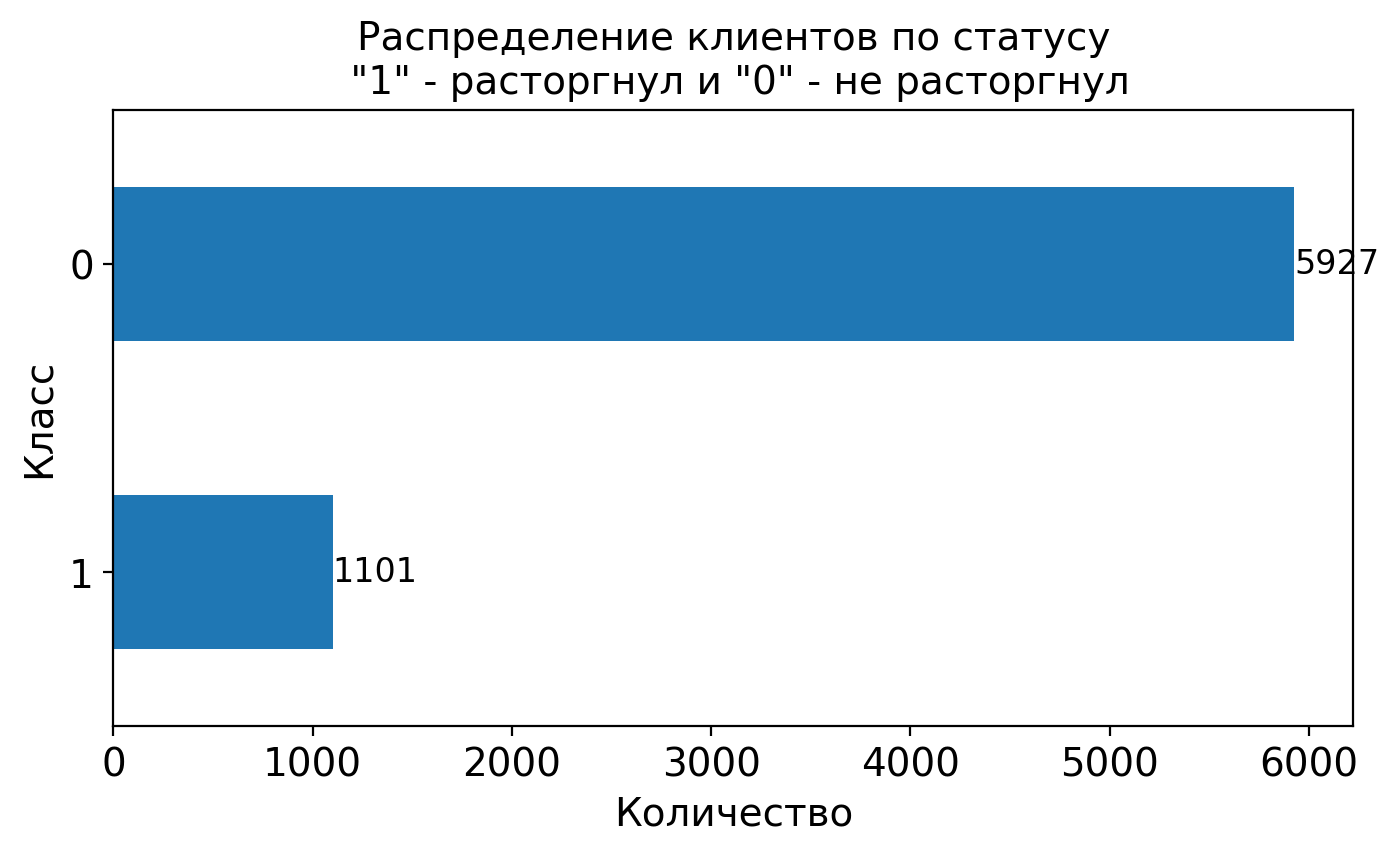

In [38]:
# построение графика
ax = combined['quit'] \
    .value_counts(ascending=True) \
        .to_frame() \
        .plot(y='quit', kind='barh',
              legend=False, figsize=(8, 4))

plt.title('Распределение клиентов по статусу\n "1" - расторгнул и "0" - не расторгнул')
plt.ylabel('Класс')
plt.xlabel('Количество')

# добавление меток для каждого столбца
for index, value in enumerate(combined['quit'].value_counts(ascending=True)):
    ax.text(value, index, str(value), ha='left', va='center', fontsize=12)

plt.show()

Налицо дисбаланс классов: действующих абонентов (класс "0") в 5.4 раз больше, чем ушедших (класс "1"). Необходимо будет это учесть при разделении датасета на обучающую и тестовую выборки. Для оценки качества будем использовать метрику ROC-AUC, которая нечувствительна к дисбалансу классов.

Построим графики отдельно для каждого класса для того, чтобы выявить закономерности.

In [39]:
quit = combined.query('quit == 1')
stay = combined.query('quit == 0')

def build_hist_cont_feature(feature, feature_name, b):
    # входные данные:
    # feature - название столбца с количественным признаком,
    # feature_name - название признака
    # b - количество бинов для гистограммы

    print(f'Статистика для клиента, расторгнувшего договор\n\n {quit[feature].describe()}')
    print(f'Статистика для клиента, не расторгнувшего договор\n\n {stay[feature].describe()}')

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
    plt.suptitle(feature_name+' в зависимости от статуса клиента')

    axes[0].hist(quit[feature], histtype='step', bins = b, linewidth=5, alpha=0.7, label='Расторгнул', density=True)
    axes[0].hist(stay[feature], histtype='step', bins = b, linewidth=5, alpha=0.7, label='Не расторгнул', density=True)
    axes[0].set_title('Распределение признака в зависимости от статуса клиента')
    axes[0].set_ylabel('Плотность')
    axes[0].legend()

    axes[1].boxplot(quit[feature], positions=[1], widths=0.6, vert=False)
    axes[1].boxplot(stay[feature], positions=[2], widths=0.6, vert=False)
    axes[1].set_title('Разброс значений признака')
    axes[1].set_yticklabels(['Расторгнул', 'Не расторгнул'])
    axes[1].set_xlabel(feature_name)
    plt.show()

Статистика для клиента, расторгнувшего договор

 count    1101.000000
mean       75.546004
std        29.116213
min        18.400000
25%        56.150000
50%        84.200000
75%        99.500000
max       118.750000
Name: monthly_charges, dtype: float64
Статистика для клиента, не расторгнувшего договор

 count    5927.000000
mean       62.815151
std        29.830236
min        18.250000
25%        30.200000
50%        69.250000
75%        87.325000
max       118.600000
Name: monthly_charges, dtype: float64


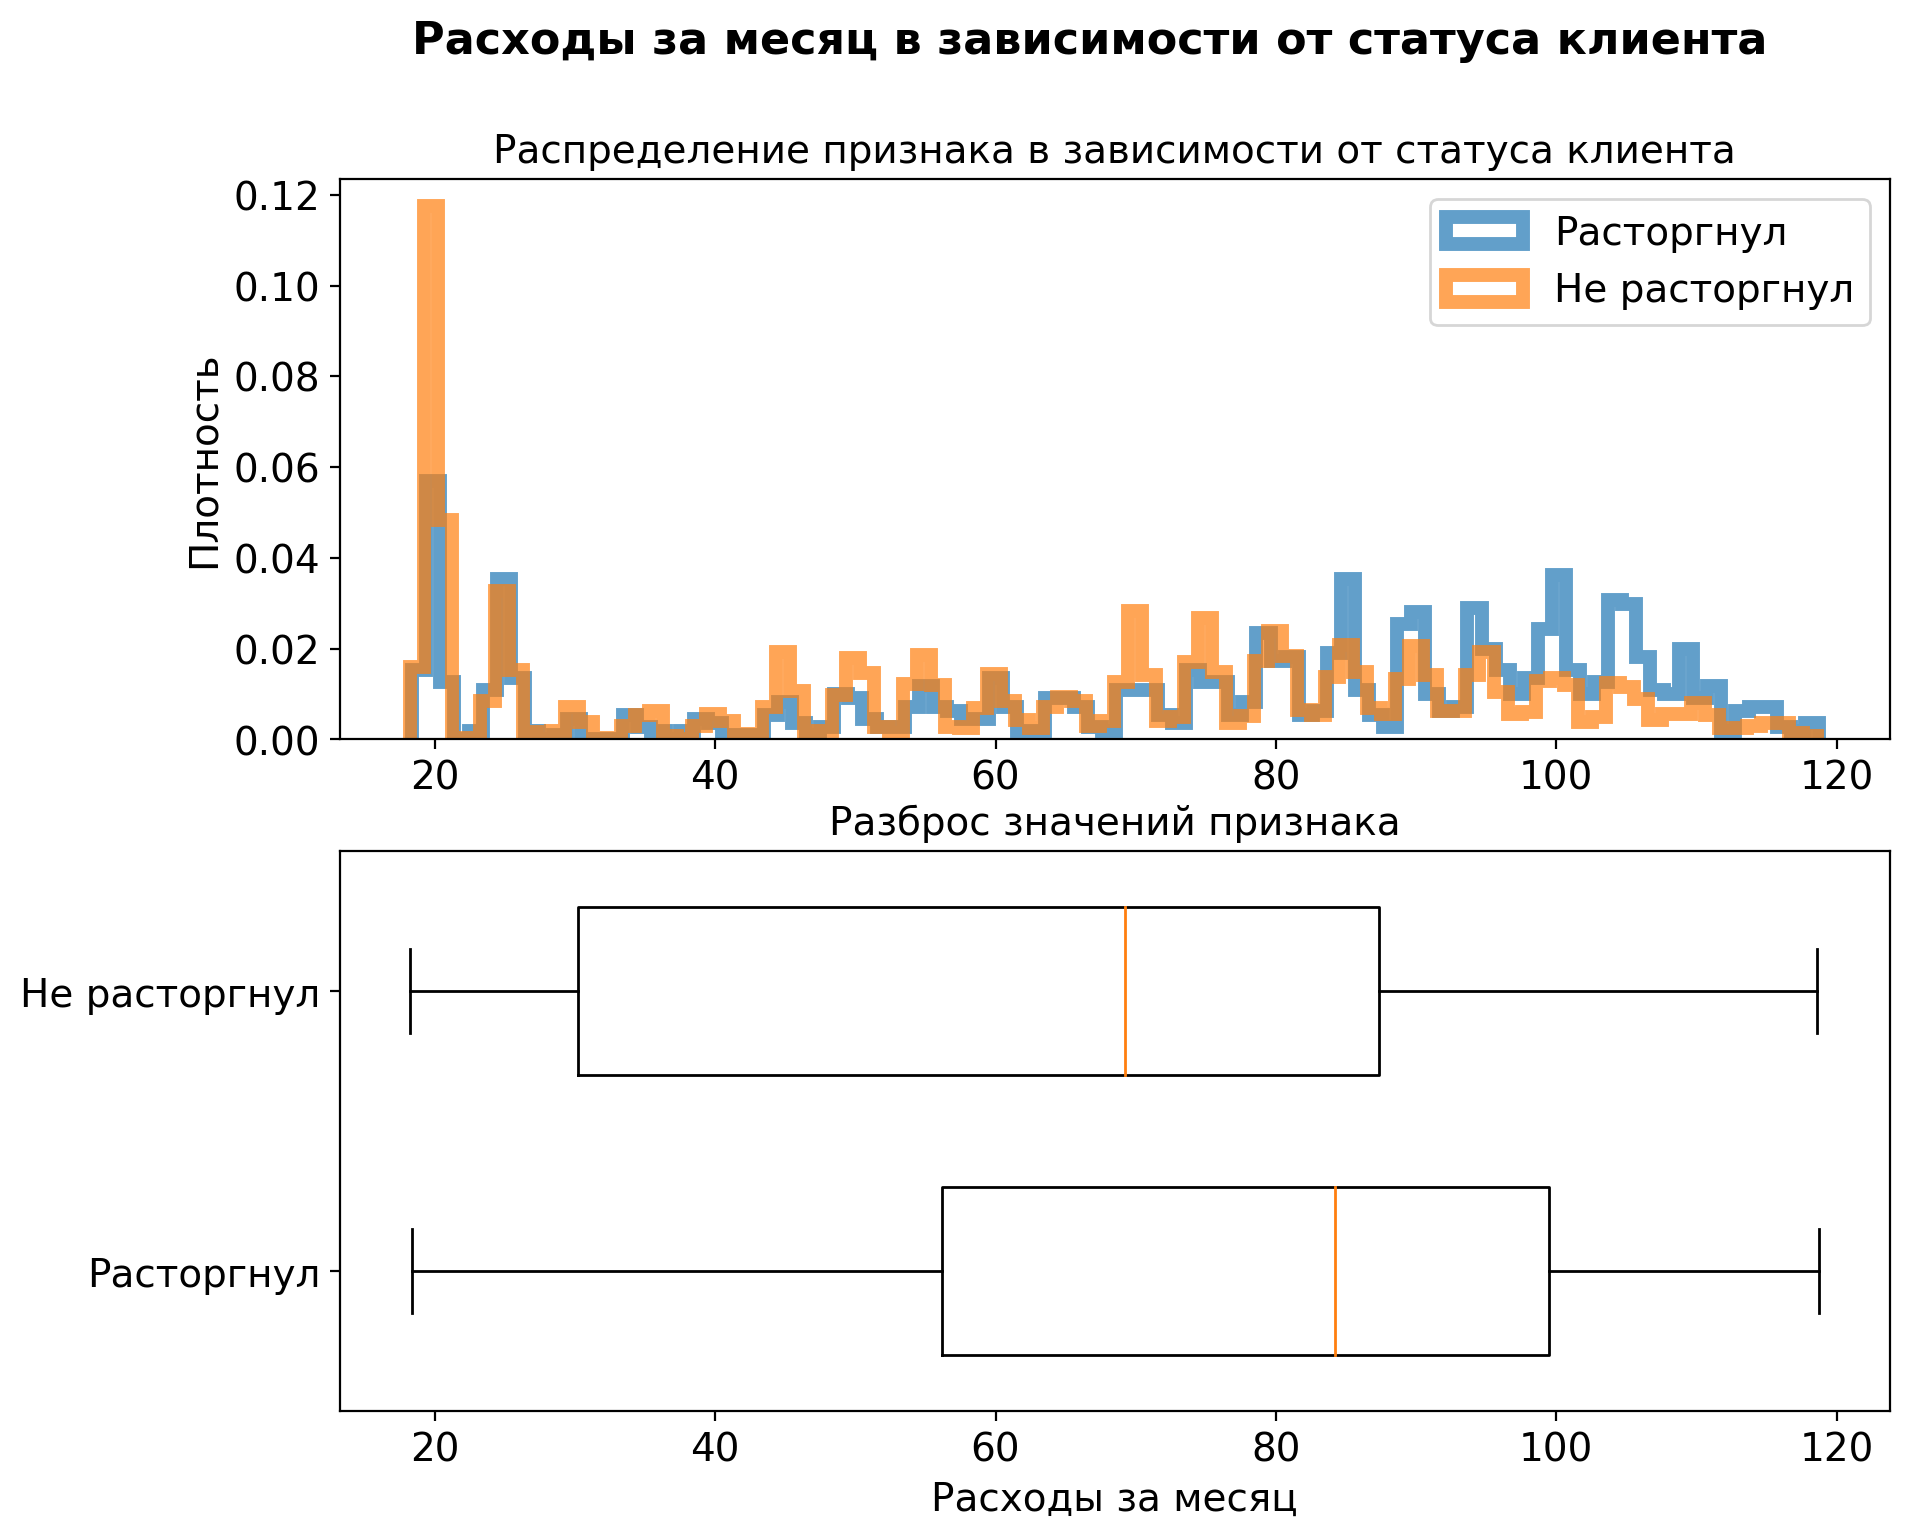

In [40]:
# вызов функции для вывода описательной статистики и построения гистограммы и боксплота
build_hist_cont_feature('monthly_charges', 'Расходы за месяц', 100)

По гистограмме и диаграмме размаха видно, что медианные месячные расходы расторгнувших договор на 14.85 денежных единиц/месяц выше, чем у действующих абонентов. Это может оказаться одной из основных причин расторжения договора.
По гистограмме также отчётливо выделяется пик около 20 д.е. Причем для действующих клиентов он выше, чем для тех кто расторгнул договор. Вероятно, он соответствует клиентам, оплачивающим услуги по специальному тарифу/акции. Из этого также можно сделать вывод, что для некоторых абонентов величина месячных расходов не является определяющей при выборе оператора связи, т.к. даже при относительно низких расходах они расторгли договор.

Статистика для клиента, расторгнувшего договор

 count    1101.000000
mean     2371.377275
std      1581.862275
min        77.840000
25%      1048.050000
50%      2139.030000
75%      3404.910000
max      7649.760000
Name: total_charges, dtype: float64
Статистика для клиента, не расторгнувшего договор

 count    5927.000000
mean     2071.398999
std      2193.086743
min        19.050000
25%       377.000000
50%      1194.280000
75%      3176.000000
max      9221.380000
Name: total_charges, dtype: float64


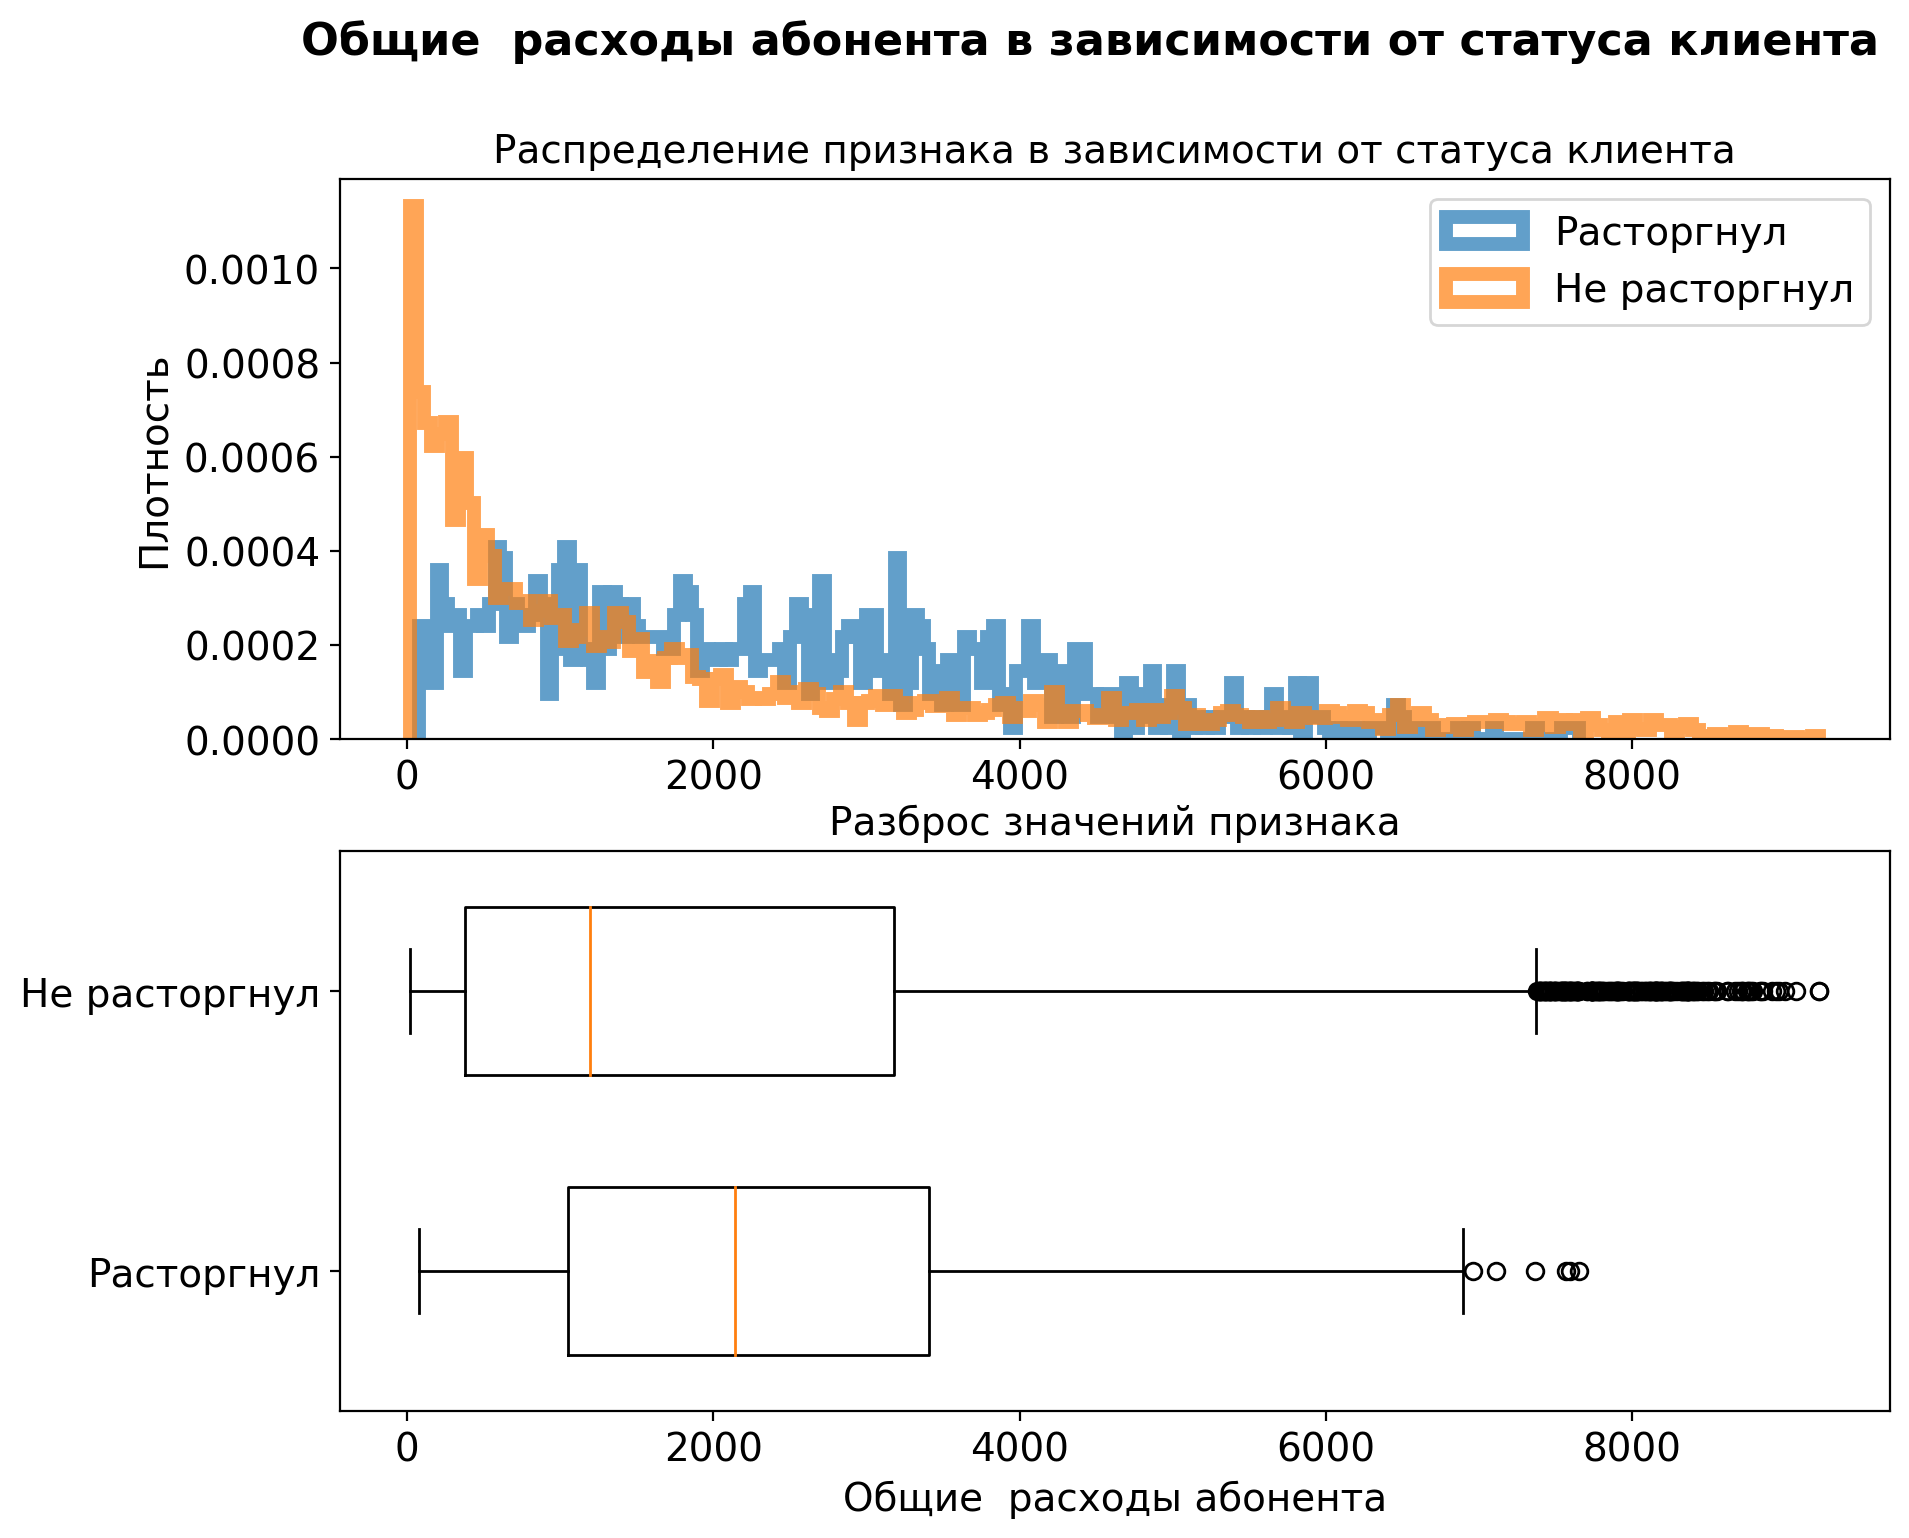

In [41]:
# вызов функции для вывода описательной статистики и построения гистограммы и боксплота
build_hist_cont_feature('total_charges', 'Общие  расходы абонента', 200)

In [42]:
stay['total_charges'].mode()

0     20.45
1    101.00
Name: total_charges, dtype: float64

Гистограмма распределения общих расходов для двух классов клиентов демонстрирует разный характер для расторгнувших и не расторгнувших договор клиентов. Гистограмма для действующих абонентов имеет форму распределения Пуассона с пиками около 20 и 101 ден.ед. и длинным правым хвостом, соответствующим абонентам, давно оформившим договор.
Сравнение медианных значений (2139 vs. 1202.49 ден.ед.) показывает, что абоненты, расторгнувшие договор, принесли компании больше денег, чем действующие.

Статистика для клиента, расторгнувшего договор

 count    1101.000000
mean      924.863760
std       458.771309
min        28.000000
25%       577.000000
50%       915.000000
75%      1249.000000
max      2129.000000
Name: duration, dtype: float64
Статистика для клиента, не расторгнувшего договор

 count    5927.000000
mean      895.193015
std       716.258826
min        31.000000
25%       245.000000
50%       702.000000
75%      1523.000000
max      2314.000000
Name: duration, dtype: float64


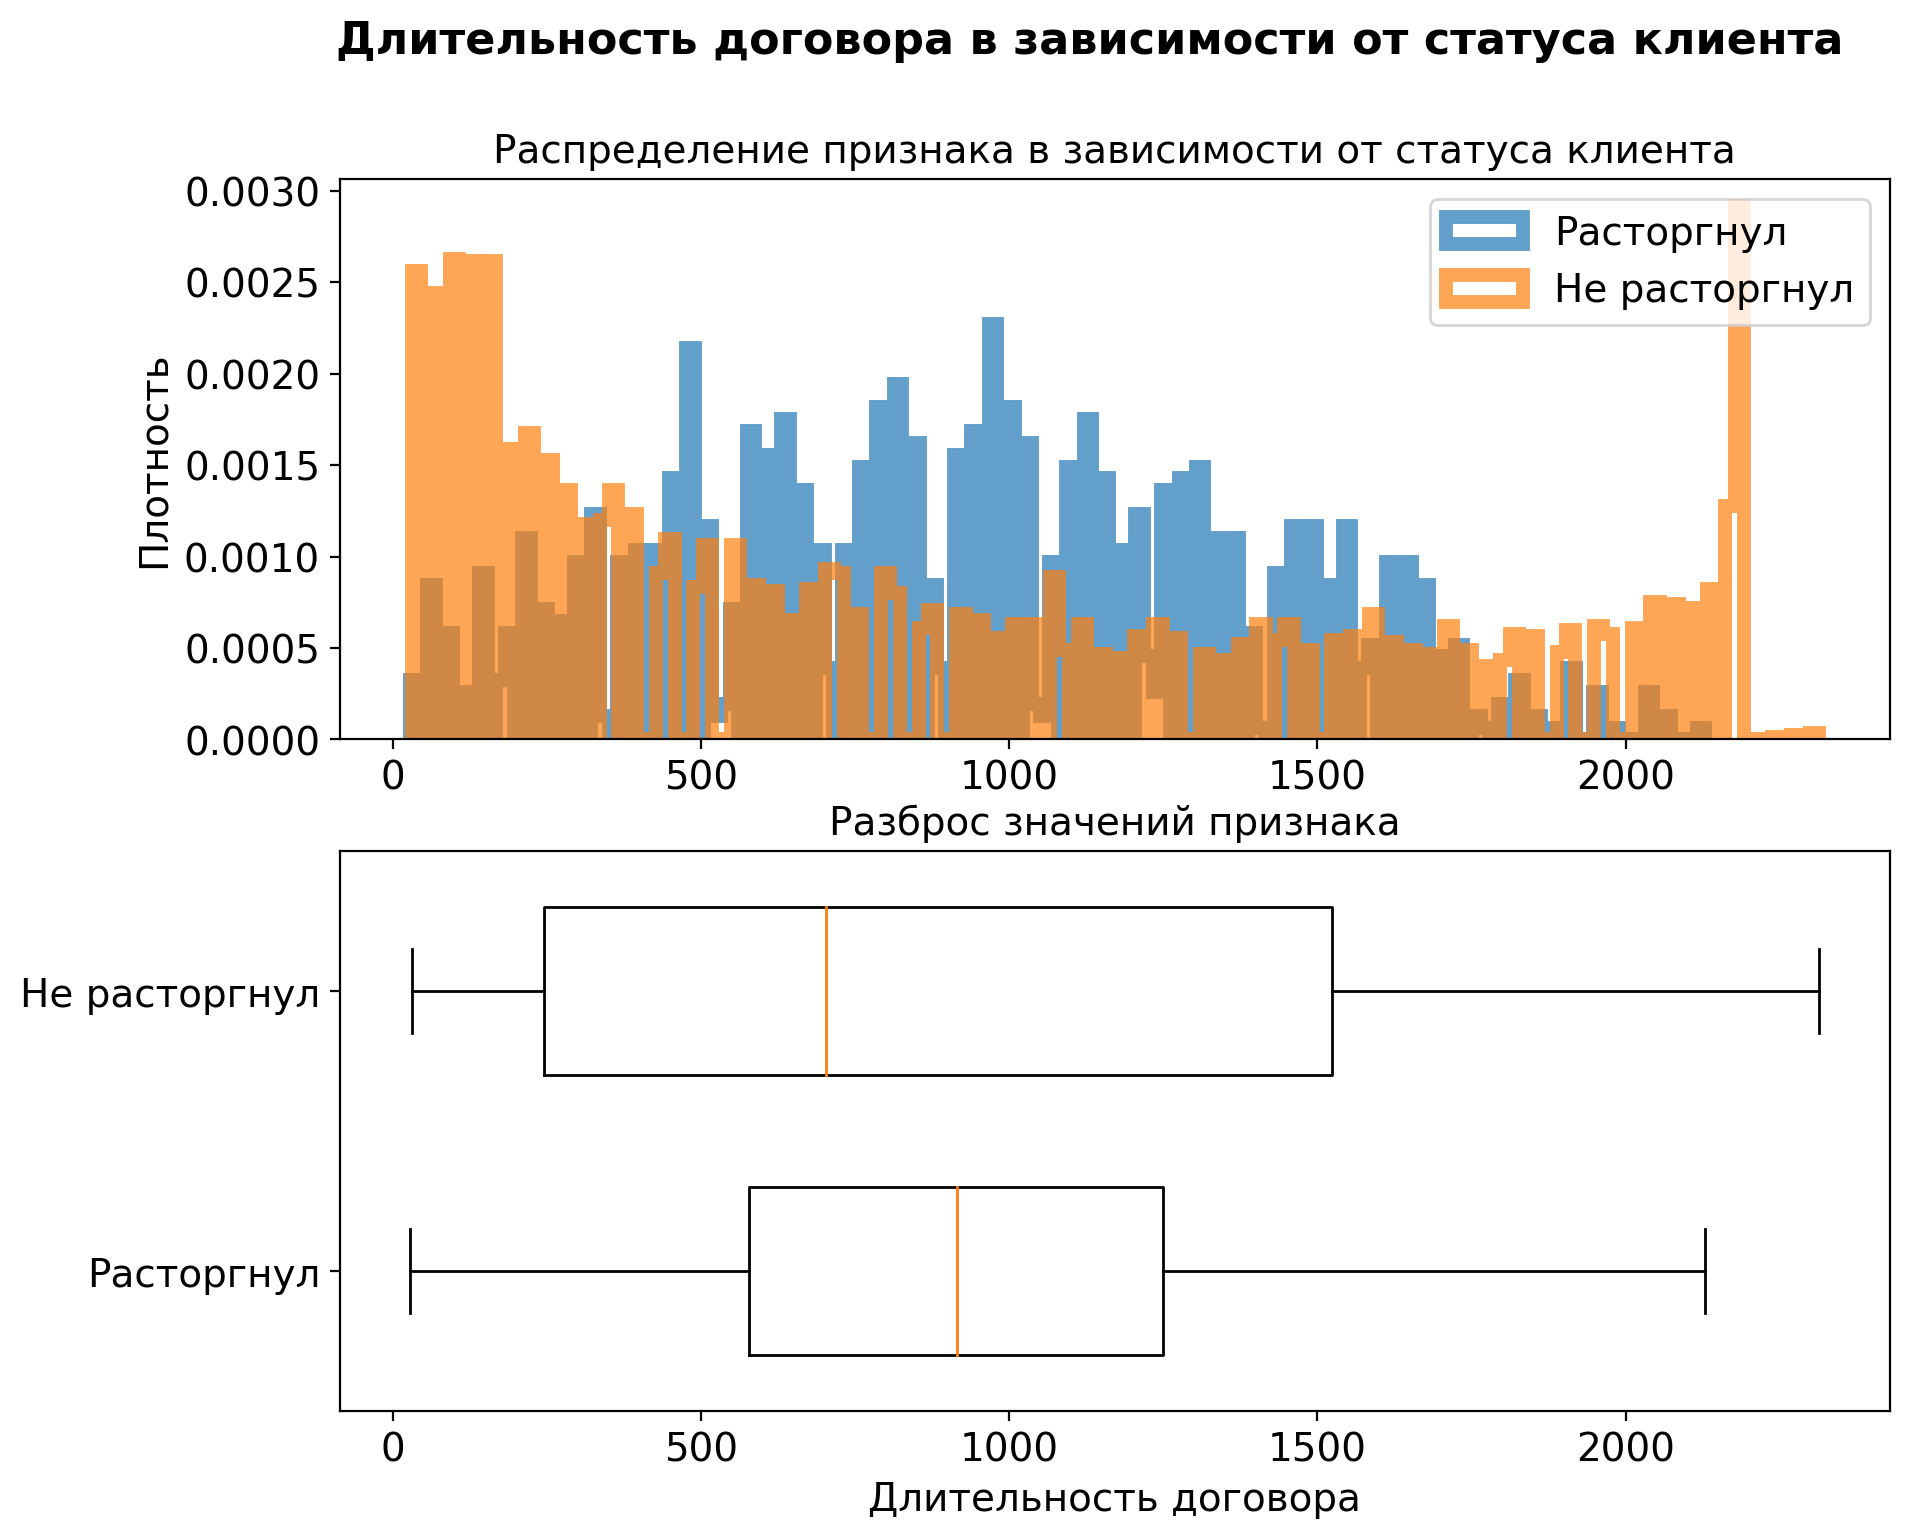

In [43]:
# вызов функции для вывода описательной статистики и построения гистограммы и боксплота
build_hist_cont_feature('duration', 'Длительность договора', 150)

In [44]:
stay['duration'].mode()

0    2191
Name: duration, dtype: int64

По гистограмме распределения длительности договора видно, что присутствуют две крупные группы действующих абонентов - это новые, которые заключили договор менее года назад и те, которые уже более 2000 дней как заключили договор. Гистограмма распределения для расторгнувших договор близка к нормальной. В среднем длительность контракта у ушедших клиентов на 30 дней дольше, чем у действующих. Отсюда как раз и вытекает причина, почему у расторгнувших договор клиентов средние общие расходы `total_charges` выше, чем у действующих.


Посмотрим как меняется количество пользователей, расторгнувших договор и только что оформивших.

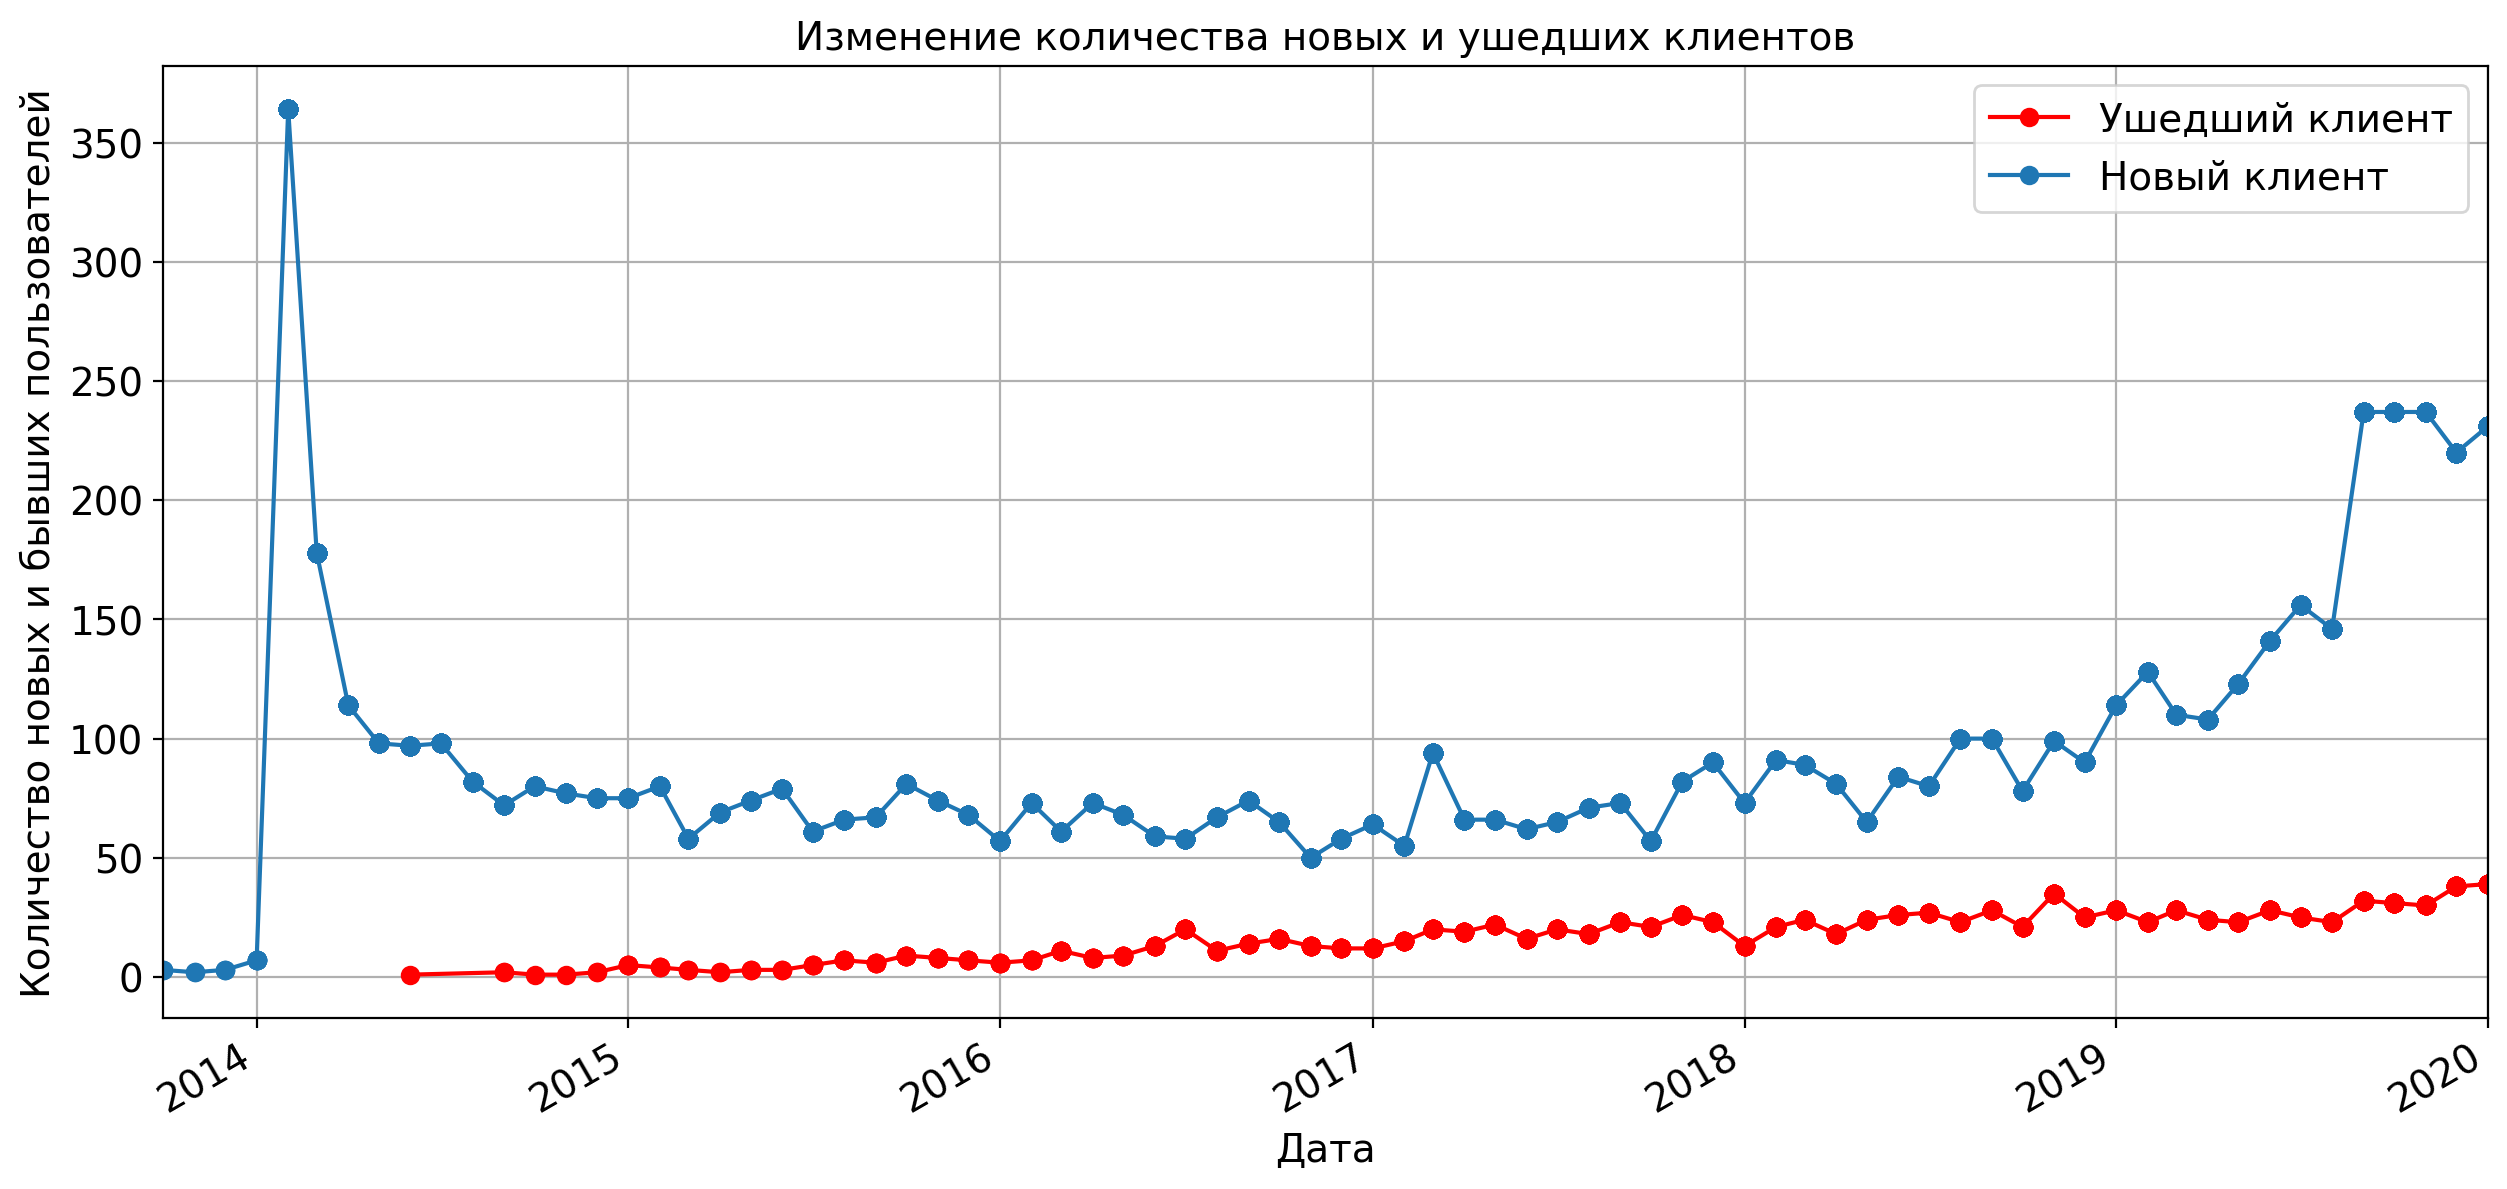

In [45]:
# построение графика изменения количества пользователей со временем
combined.query('end_date < "2020-02-01"').plot('end_date', 'num_quit_clients',
                                               color='r', style='o-',
                                               label='Ушедший клиент',
                                               figsize=(15, 7),
                                               xlim=('2013-10-01', '2020-01-01')
                                              )
plt.plot('begin_date', 'num_new_clients', 'o-', data=combined, label='Новый клиент')
plt.title('Изменение количества новых и ушедших клиентов')
plt.xlabel('Дата')
plt.ylabel('Количество новых и бывших пользователей')
plt.grid(True)
plt.legend(loc="best")
plt.show()

In [46]:
# посмотрим на численные значения строчки с данными, когда новых пользователей было больше 200
combined[['begin_date', 'end_date', 'num_new_clients', 'num_quit_clients']] \
            .query('num_new_clients > 200 and end_date < "2020-02-01"')

begin_date   end_date  num_new_clients  num_quit_clients
customerID                                                         
0078-XZMHT 2014-02-01 2016-07-01              364                20
9924-JPRMC 2014-02-01 2018-09-01              364                28
2234-EOFPT 2014-02-01 2016-09-01              364                14
8338-QIUNR 2014-02-01 2016-05-01              364                 9
8224-KDLKN 2014-02-01 2019-01-01              364                28
...               ...        ...              ...               ...
2984-TBYKU 2014-02-01 2017-09-01              364                23
9225-BZLNZ 2014-02-01 2016-08-01              364                11
5997-OPVFA 2014-02-01 2015-06-01              364                 3
3165-HDOEW 2019-09-01 2020-01-01              237                39
9878-TNQGW 2019-10-01 2019-11-01              237                30

[103 rows x 4 columns]

In [47]:
# посмотрим на разницу между количеством пришедших и ушедших клиентов
combined \
          .query('end_date < "2020-02-01"') \
          .pivot_table(index='begin_date',
                       values=['num_new_clients', 'num_quit_clients'],
                       aggfunc='mean')

num_new_clients  num_quit_clients
begin_date                                   
2013-12-01                3         11.000000
2014-01-01                7         14.000000
2014-02-01              364         17.475248
2014-03-01              178         17.269841
2014-04-01              114         19.925000
...                     ...               ...
2019-06-01              141         31.000000
2019-07-01              156         34.400000
2019-08-01              146         36.000000
2019-09-01              237         39.000000
2019-10-01              237         30.000000

[69 rows x 2 columns]

По графику видно, что в начале исследуемого периода до февраля 2014 года был небольшой прирост пользователей от 3х до 7 в январе 2014. Затем следует пиковое количество зарегистрировавшихся пользователей равное 364 чел. 1го февраля 2014. Далее до 2019 года количество пользователей колеблется около значения 70 чел. И после 2019 года количество новых пользователей стало расти и во второй половине 2019 года стало в среднем 235 новых пользователей в месяц.

График изменения количества ушедших пользователей демонстрирует медленно растущий тренд. В целом наблюдается положительный прирост: количество новых клиентов превышает количество ушедших в среднем на 200 человек.

Удалим признаки 'begin_date', 'end_date', 'num_new_clients', 'num_quit_clients', т.к. мы извлекли из них необходимую информацию, к тому же будет наблюдаться мультиколлениарность между ними и созданными из них признаками - 'duration', 'quit'.

In [48]:
# удаление признаков 'begin_date', 'end_date', 'num_new_clients', 'num_quit_clients'
combined = combined.drop(['begin_date', 'end_date', 'num_new_clients', 'num_quit_clients'], axis=1)
quit = quit.drop(['begin_date', 'end_date', 'num_new_clients', 'num_quit_clients'], axis=1)
stay = stay.drop(['begin_date', 'end_date', 'num_new_clients', 'num_quit_clients'], axis=1)

Построим столбчатые диаграммы и попробуем выявить различия между клиентами, расторгнувшими договор и оставшимися.

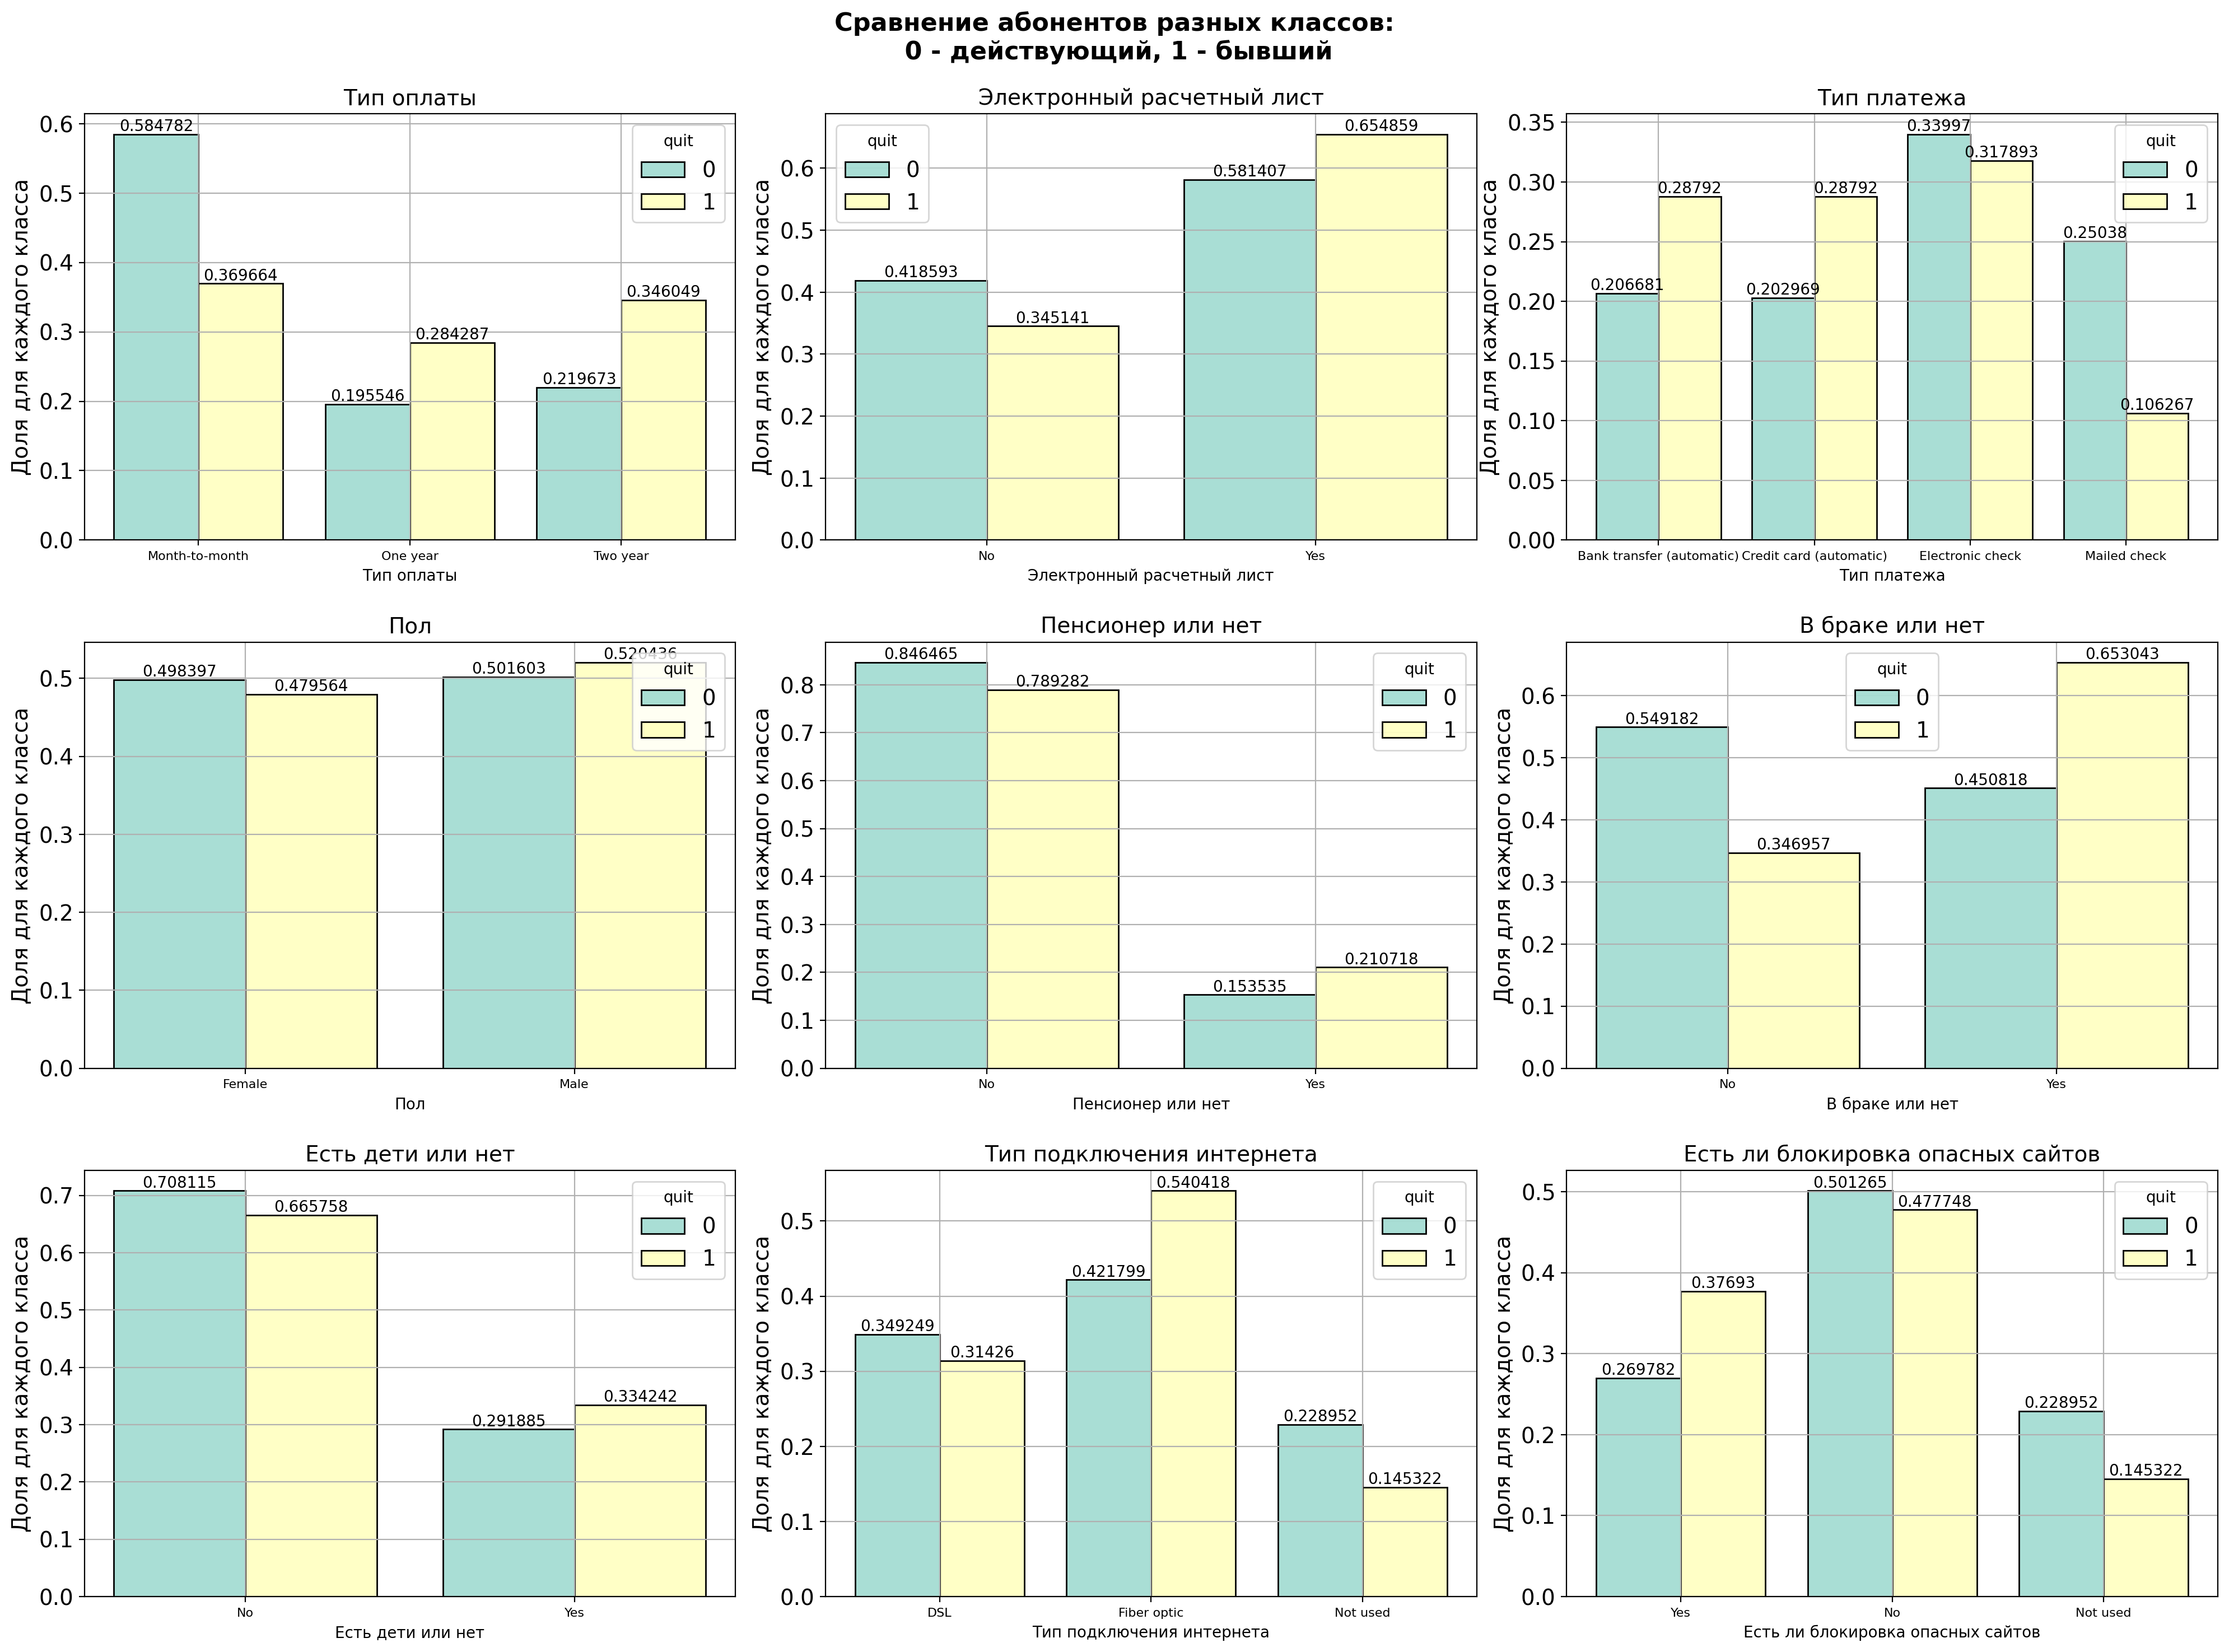

In [74]:
features = [('type', 'Тип оплаты'), ('paperless_billing', 'Электронный расчетный лист'),
            ('payment_method', 'Тип платежа'), ('gender', 'Пол'),
            ('senior_citizen', 'Пенсионер или нет'), ('partner', 'В браке или нет'),
            ('dependents', 'Есть дети или нет'), ('internet_service', 'Тип подключения интернета'),
            ('online_security', 'Есть ли блокировка опасных сайтов')
           ]

plt.figure(figsize=(20, 15))
plt.suptitle('Сравнение абонентов разных классов:\n 0 - действующий, 1 - бывший\n')
plt.subplots_adjust(hspace = 0.6, wspace = 0.6, top=0.85)

# цикл для перебора характеристик сотрудника с построением горизонтальной столбчатой диаграммы
for i, feature in enumerate(features):
    ax = plt.subplot(3, 3, i+1)
    ax.grid(True)
    ax.set_title(feature[1])
    ax.set_xlabel(feature[1], fontsize=10)
    ax.tick_params(axis='x', rotation=0, labelsize=8)
    ax.set_ylabel('Доля для каждого класса')

    sns.histplot(x=feature[0], hue='quit', data=combined, ax=ax, palette='Set3', multiple="dodge",
                  stat = 'density', shrink = 0.8, common_norm=False)
    for label in ax.containers:
      ax.bar_label(label)
plt.tight_layout(h_pad=2)

В целом статус клиента ("ушел"/"не ушел") не сильно влияет на распределение.
Можно ожидать, что у признаков `payment_method`, `partner` будут чуть выше корреляционные связи с целевым. А признак `gender` не влияет на целевой признак.

построим также графики для числовых признаков.

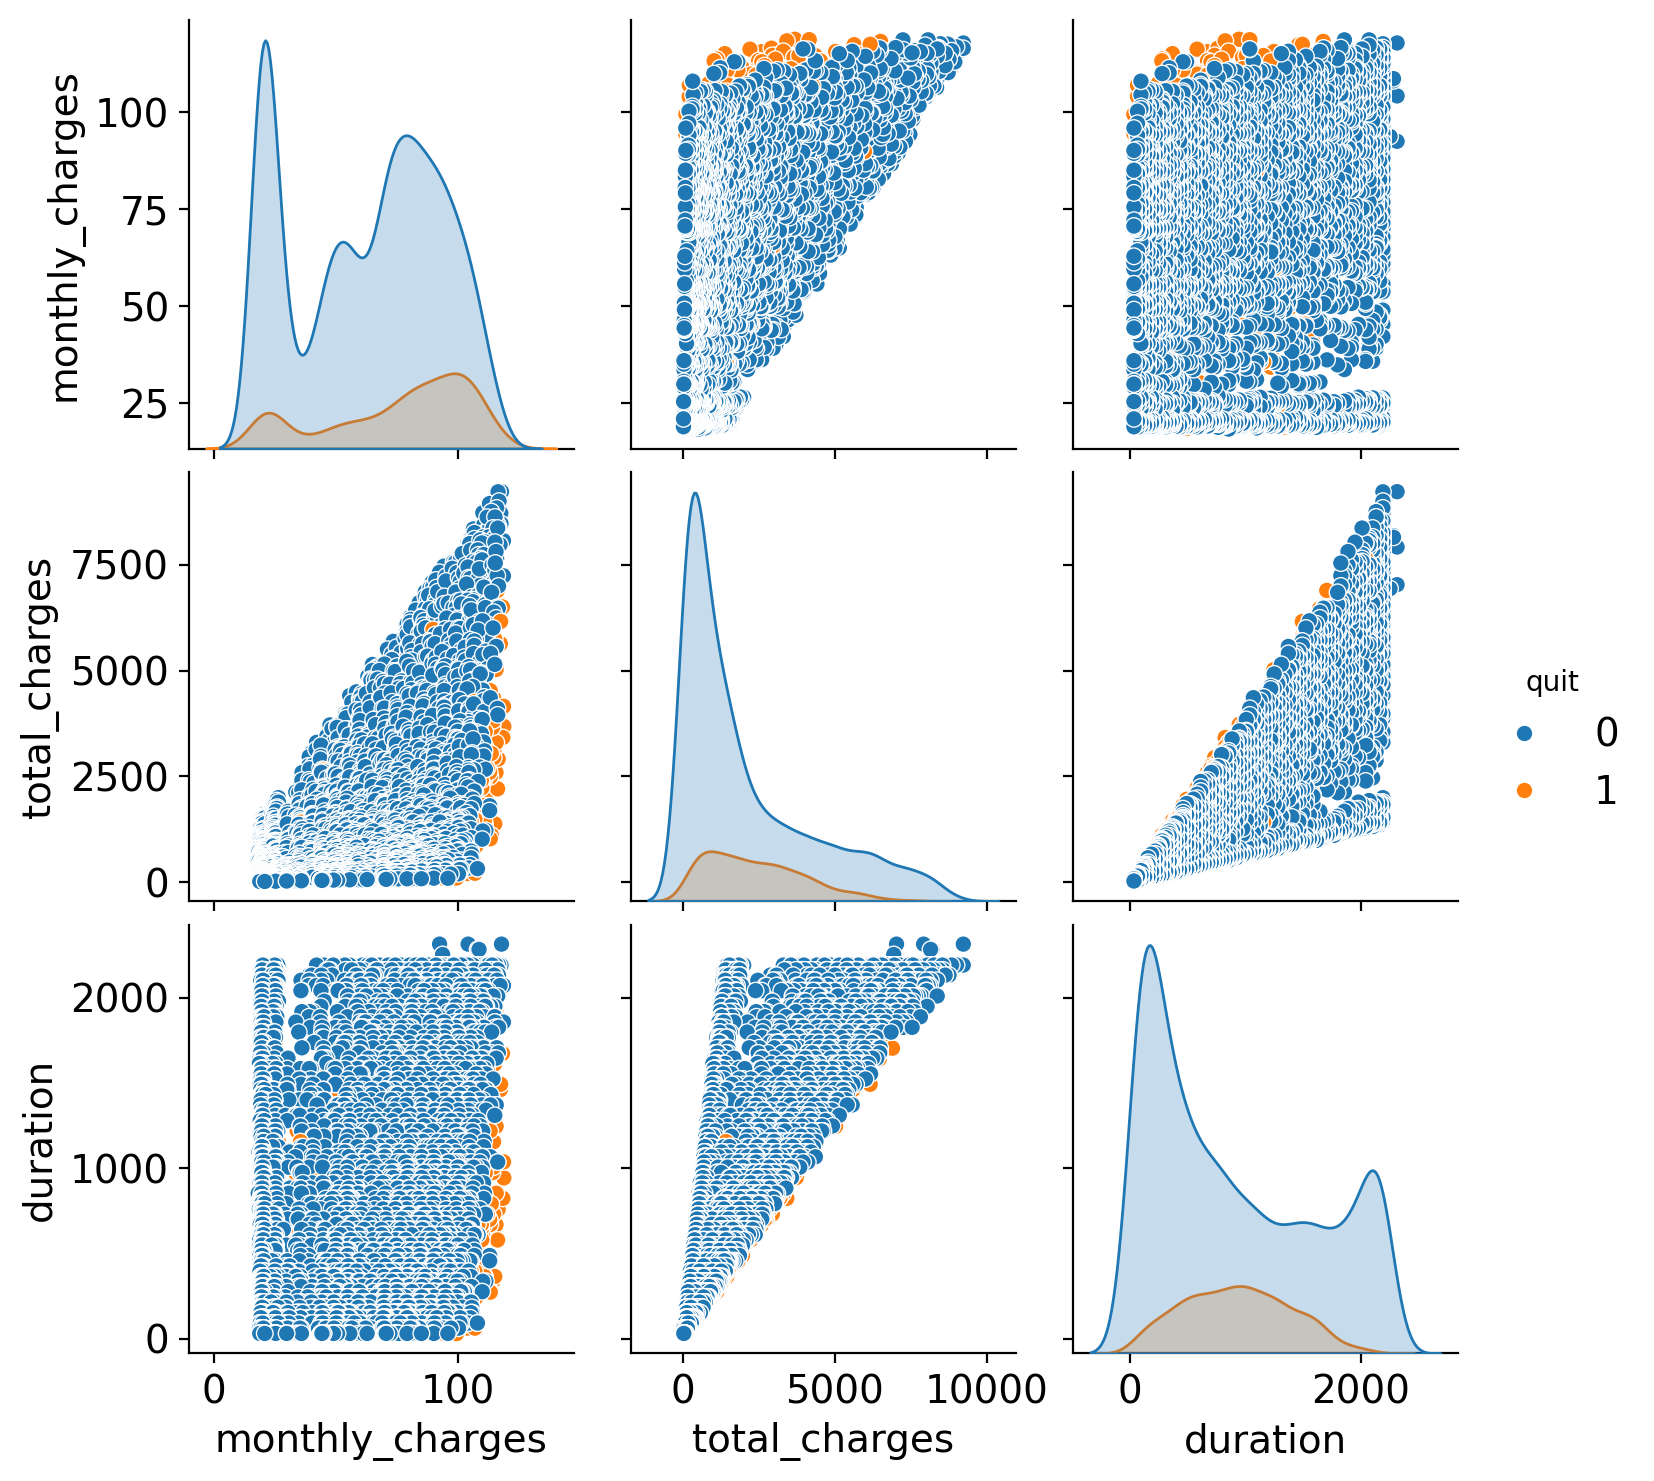

In [50]:
sns.pairplot(combined, hue='quit')

По графикам видно хорошие прямые линейные связи между признаками `total_charges`-`monthly_charges` и `duration`-`total_charges`. На следующем этапе построим корреляционную матрицу и оценим количественно величину связи между признаками.

## Корреляционный анализ

Рассчитаем коэффициенты корреляции между признаками разных типов данных. Для этого используем библиотеку phik.

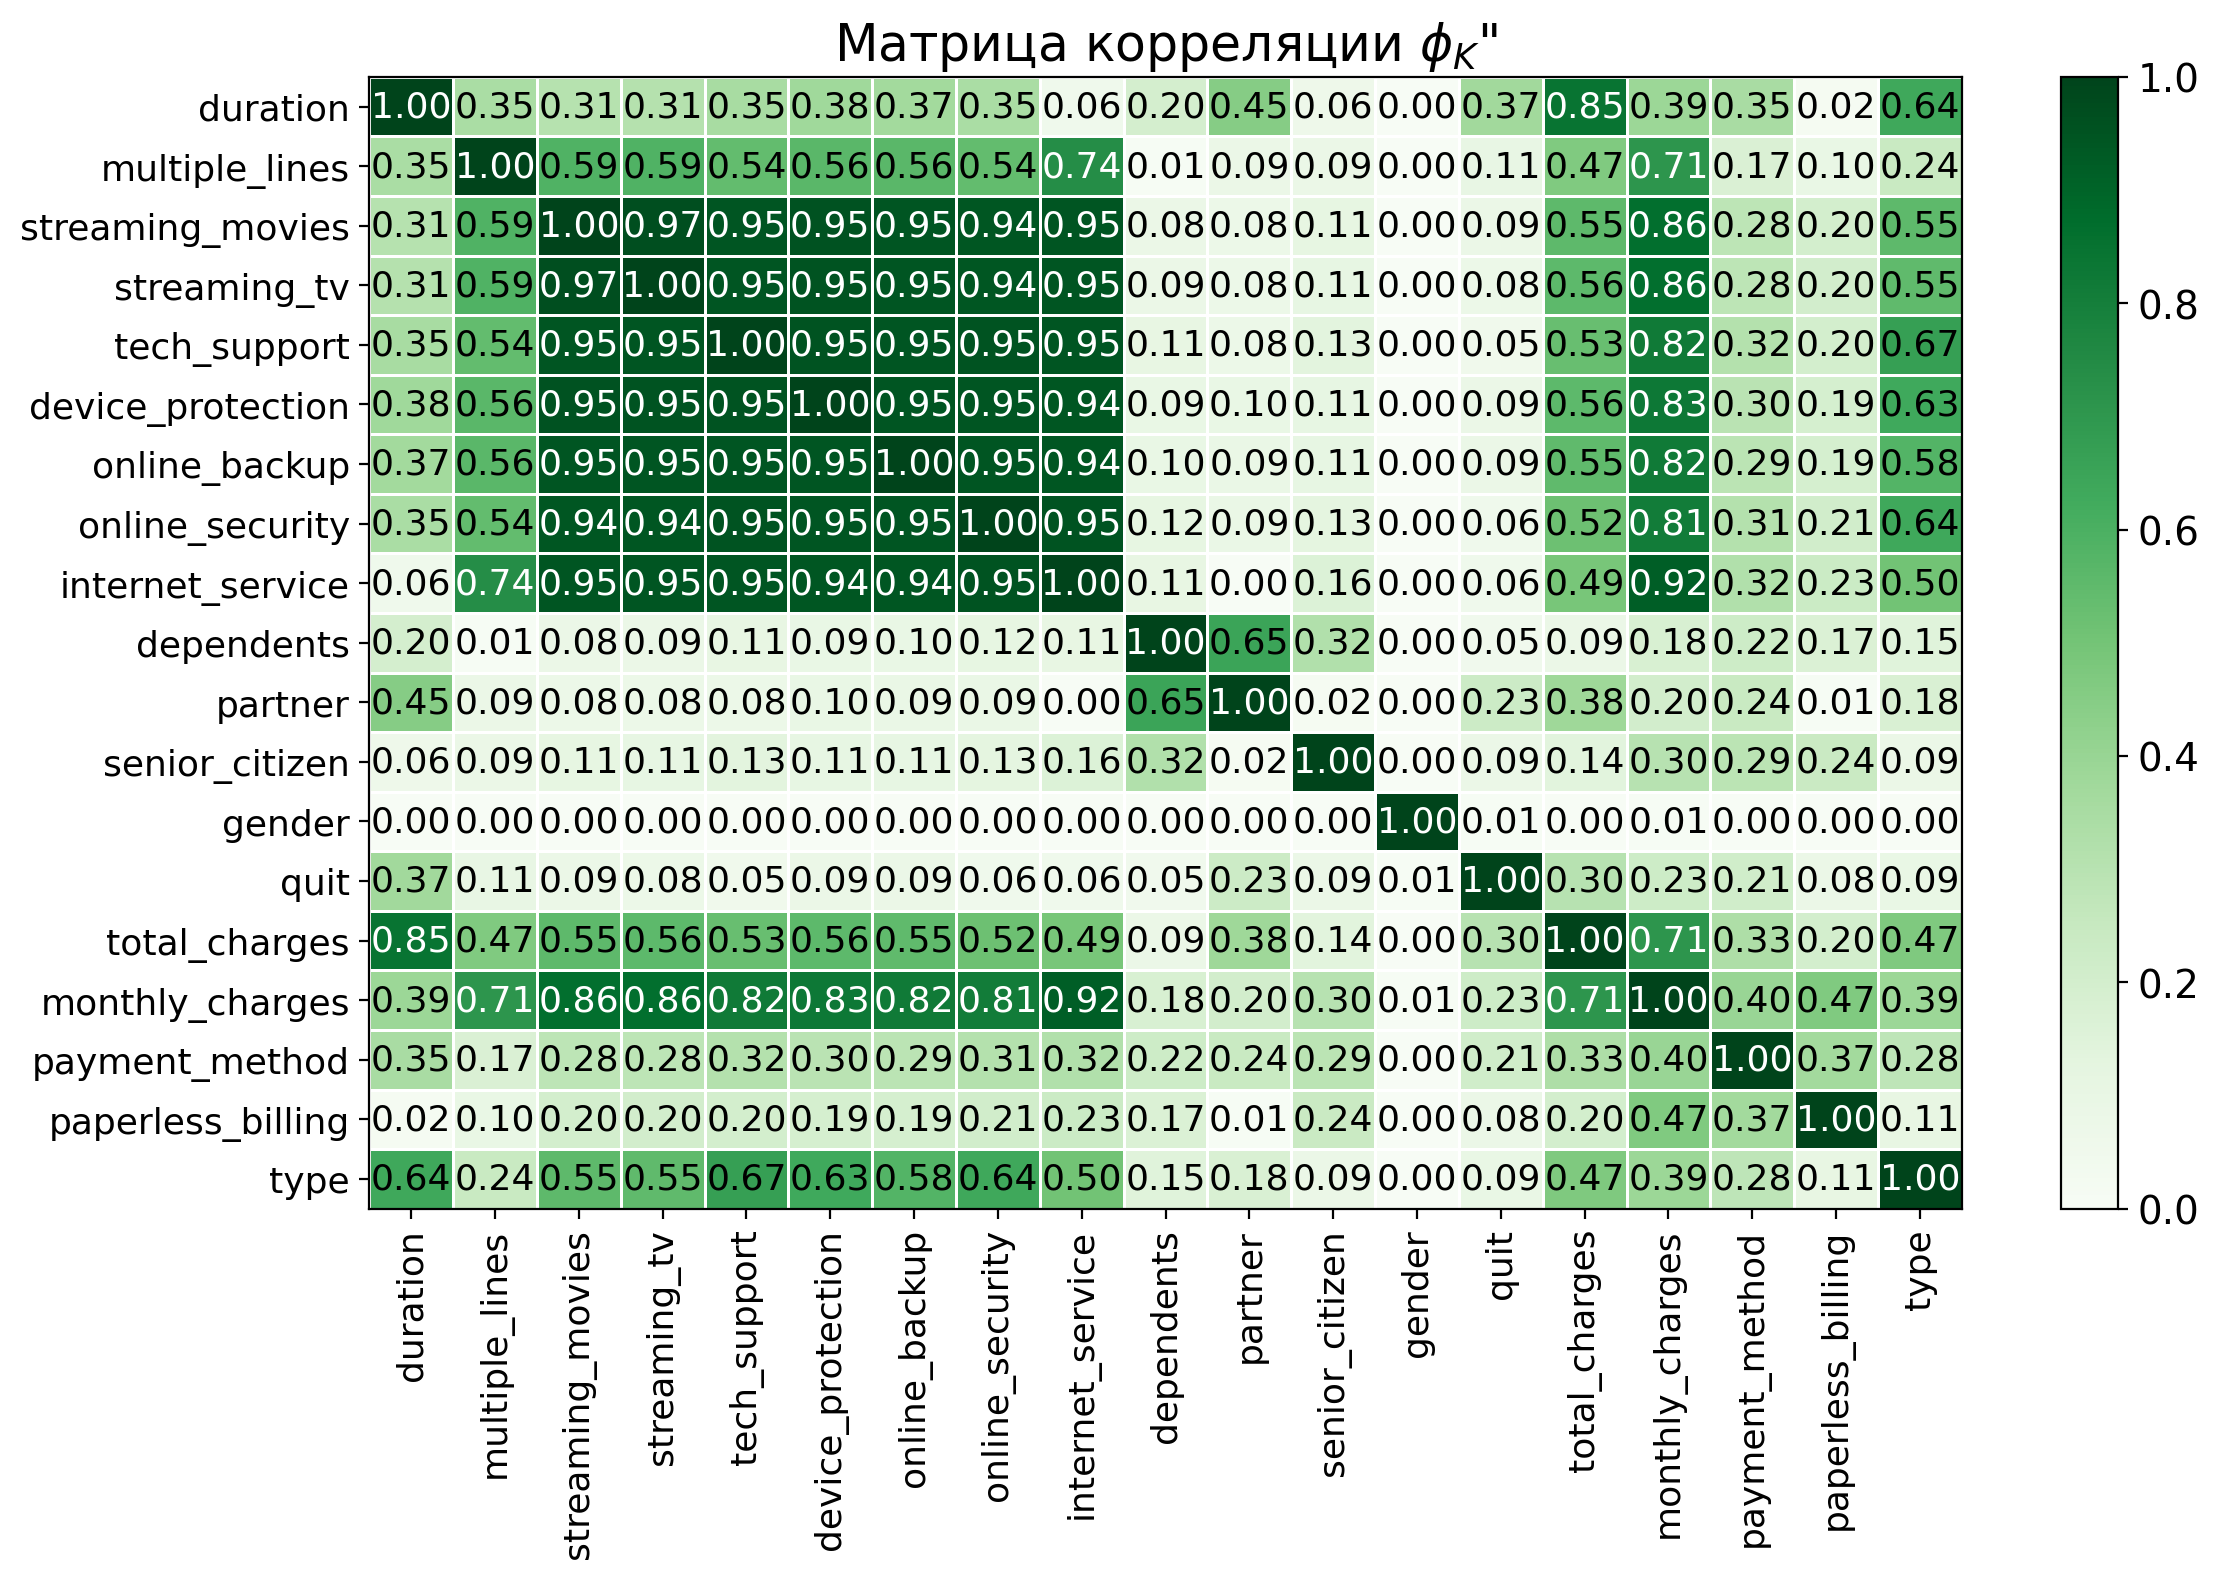

In [51]:
# создаём список с наименованиями непрерывных признаков
interval_cols = ['monthly_charges', 'total_charges', 'duration', 'num_new_clients', 'num_quit_clients']

# считаем коэффициенты корреляции
phik_overview= phik_matrix(combined, interval_cols=interval_cols)

# строим матрицу корреляции для класса 'Клиент, расторгнувший договор'
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Матрица корреляции $\phi_K$"',
    fontsize_factor=1.3,
    figsize=(12, 8)
)
plt.show()


По матрице корреляции phik видно, что существует очень сильная корреляционная связь между признаками (от 94 до 97%), относящимися к интернет-услугам: **internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies**. Похоже эти услуги предоставляются пакетом, поэтому между ними такая сильная взаимосвязь и в таких случаях говорят о мультиколлинеарности входных признаков. Это может негативно сказаться на моделировании, поэтому оставим из них один признак, например streaming_movies, т.к. у него коэффициент корреляции с таргетом чуть выше остальных - 9%, а остальные удалим.

Кроме того, у вышеперечисленных признаков высокая корреляционная связь (82-86%) с месячными расходами (**monthly_charges**), что и понятно, дополнительные услуги предоставляются за дополнительную плату.

У признака **gender** практически нулевая взаимосвязь со всеми признаками, поэтому этот признак тоже удалим.

## Обучение модели

Протестируем 3 модели: LogisticRegression, CatBoostClassifier и SGDClassifier. Для модели CatBoostClassifier нет необходимости кодировать категориальные признаки и масштабировать численные, поэтому для нее будем подавать "сырые" данные. Для остальных же моделей воспользуемся OneHotEncoder для категориальных признаков и StandardScaler() для числовых.

In [52]:
# список столбцов с категориальными признаками
cat_columns = ['type', 'paperless_billing', 'payment_method', 'senior_citizen',
       'partner', 'dependents', 'streaming_movies', 'multiple_lines']

combined[cat_columns] = combined[cat_columns].astype('category')

# список столбцов с количественными признаками
num_columns = ['monthly_charges', 'total_charges', 'duration']

In [53]:
# записываем входные данные в переменную Х, целевой признак в переменную у
X = combined.drop(['quit', 'gender', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv'], axis=1)
y = combined['quit']

# делим выборку на тренировочную и тестовую со статификацией по целевому признаку
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = y)

print(f"Размер обучающей выборки: {X_train.shape}, тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (5271, 11), тестовой выборки: (1757, 11)


Разбили исходный датасет в соотношении train/test 3:1.

In [55]:
# создание пустого списка для добавления лучших метрик по всем лучшим моделям
rocauc_cv = []

def prep_model_pipe(model, params):
    '''
    Функция, которая подготавливает признаки, производит подбор гиперпараметров и
    возвращает лучшую модель
    '''
    # соберём пайплайн подготовки данных
    # SimpleImputer + OHE
    ohe_pipe = Pipeline([
        (
            'simple_imputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        ('ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ])

    data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)


    # финальный пайплайн
    pipeline = Pipeline([
        ('preprocessor', data_preprocessor),
        ('clf', model),
    ])

    gs = GridSearchCV(
        pipeline,
        param_grid=params,
        cv=3,
        scoring='roc_auc',
        n_jobs=1
    )

    # запуск поискa  лучших гиперпараметров
    gs.fit(X_train, y_train)

    print('Параметры лучшей модели:\n\n', gs.best_estimator_)

    rocauc_cv.append(gs.best_score_)

    return gs.best_estimator_

### Модель LogisticRegression

In [56]:
# словарь с параметрами для LogisticRegression
lr_params = {'clf__C': range(1, 15, 3),
             'clf__C': [0.1, 5, 10],
            'preprocessor__num': [StandardScaler(), MinMaxScaler()]
            }

# инициализируем модель LogisticRegression
model_lr = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', max_iter=200)

# вызов функции с расчетом матрицы признаков и подбором гиперпараметров для LogisticRegression
model_lr = prep_model_pipe(model_lr, lr_params)

Параметры лучшей модели:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simple_imputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['type', 'paperless_billing',
                                                   'payment_method',
                                                   'senior_citizen', 'partner',
               

### Модель CatBoostClassifier

In [57]:
# словарь с параметрами для CatBoostClassifier()
cbc_params = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [4, 8],
        'l2_leaf_reg': [3, 5, 100]
    }

# инициализируем модель CatBoostClassifier()
model_cbc = CatBoostClassifier(custom_metric=['AUC'], eval_metric='AUC')

# подбор гиперпараметров для CatBoostClassifier()
gs = model_cbc.grid_search(cbc_params,
                           Pool(X_train, y_train, cat_features=cat_columns),
                           cv=3,
                           verbose=100)

print('Параметры лучшей модели:\n\n', gs['params'])

Выходные данные были обрезаны до нескольких последних строк (5000).
32:	test: 0.8444722	best: 0.8490468 (20)	total: 209ms	remaining: 6.12s
33:	test: 0.8463397	best: 0.8490468 (20)	total: 218ms	remaining: 6.2s
34:	test: 0.8466906	best: 0.8490468 (20)	total: 226ms	remaining: 6.22s
35:	test: 0.8451616	best: 0.8490468 (20)	total: 229ms	remaining: 6.13s
36:	test: 0.8436294	best: 0.8490468 (20)	total: 238ms	remaining: 6.2s
37:	test: 0.8445130	best: 0.8490468 (20)	total: 243ms	remaining: 6.14s
38:	test: 0.8451898	best: 0.8490468 (20)	total: 246ms	remaining: 6.05s
39:	test: 0.8458979	best: 0.8490468 (20)	total: 250ms	remaining: 5.99s
40:	test: 0.8461611	best: 0.8490468 (20)	total: 254ms	remaining: 5.93s
41:	test: 0.8461611	best: 0.8490468 (20)	total: 257ms	remaining: 5.87s
42:	test: 0.8471449	best: 0.8490468 (20)	total: 266ms	remaining: 5.92s
43:	test: 0.8483638	best: 0.8490468 (20)	total: 275ms	remaining: 5.97s
44:	test: 0.8481570	best: 0.8490468 (20)	total: 279ms	remaining: 5.92s
45:	test: 0

In [59]:
# добавление метрики ROC_AUC по модели CatBoost
rocauc_cv.append(np.max(gs['cv_results']['test-AUC-mean']))

In [60]:
display(gs['params'])

{'depth': 4, 'learning_rate': 0.1, 'l2_leaf_reg': 3}

In [61]:
model_cat = CatBoostClassifier(depth=gs['params']['depth'],
                               learning_rate=gs['params']['learning_rate'],
                               l2_leaf_reg=gs['params']['l2_leaf_reg'],
                               custom_metric=['AUC:hints=skip_train~false'],
                               verbose=100)
model_cat.fit(Pool(X_train, y_train, cat_features=cat_columns))

0:	learn: 0.6227268	total: 4.72ms	remaining: 4.72s
100:	learn: 0.2991619	total: 469ms	remaining: 4.18s
200:	learn: 0.2528835	total: 969ms	remaining: 3.85s
300:	learn: 0.2178225	total: 1.48s	remaining: 3.43s
400:	learn: 0.1931626	total: 1.98s	remaining: 2.96s
500:	learn: 0.1747872	total: 2.49s	remaining: 2.48s
600:	learn: 0.1606328	total: 3.11s	remaining: 2.06s
700:	learn: 0.1502173	total: 4.15s	remaining: 1.77s
800:	learn: 0.1409260	total: 4.86s	remaining: 1.21s
900:	learn: 0.1327232	total: 5.4s	remaining: 593ms
999:	learn: 0.1247139	total: 5.91s	remaining: 0us


### Модель SGDClassifier()

In [62]:
# словарь с параметрами для SGDClassifier
sgd_params = {'clf__max_iter': [200],
              'clf__alpha': [0.00001, 0.0000001],
              'clf__penalty': ['l2', 'elasticnet'],
              'preprocessor__num': [StandardScaler(), MinMaxScaler()]
             }

# инициализируем модель SGDClassifier
sgdc = SGDClassifier()

# вызов функции с расчетом матрицы признаков и подбором гиперпараметров для SGDClassifier
model_sgdc = prep_model_pipe(sgdc, sgd_params)

Параметры лучшей модели:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simple_imputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['type', 'paperless_billing',
                                                   'payment_method',
                                                   'senior_citizen', 'partner',
               

## Тестирование

Соберем все метрики ROC-AUC, оцененные на кросс-валидации по всем моделям в датафрейм.

In [63]:
result = pd.DataFrame(
    {
    "Модель": ['LogisticRegression', 'CatBoostClassifier', 'SGDClassifier'],
    "ROC-AUC на cv": rocauc_cv
    }
)

result

Модель  ROC-AUC на cv
0  LogisticRegression       0.772534
1  CatBoostClassifier       0.911945
2       SGDClassifier       0.752873

По результатам кросс-валидации лучшей оказалась модель CatBoostClassifier с параметрами {'depth': 4, 'learning_rate': 0.1, 'l2_leaf_reg': 3}. Ее метрика ROC-AUC равна 91%. Сделаем по ней прогнозы на тестовой выборке, чтобы оценить финальную метрику и чтобы проверить переобученность модели.

In [64]:
# рассчитаем прогноз и метрики на тестовых данных
y_test_pred = model_cat.predict(X_test)
y_pred = model_cat.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_test, 3)}')

Метрика ROC-AUC на тестовой выборке: 0.909


Метрика ROC-AUC на тестовых данных оказалась чуть ниже, чем на кросс-валидации - 90.9%, что свидетельствует о том, что модель немного переобучилась.

### Анализ важности

Анализ важности признаков сделаем методом SHAP, который позволяет определить как каждый отдельный признак повлиял на классификацию результата.

In [65]:
# расчет SHAP значений для модели CatBoostClassifier
explainer = shap.TreeExplainer(model_cat)
shap_values = explainer(X_test)

Посмотрим также на столбчатую диаграмму 'shap.plots.bar', которая показывает средние SHAP-значения по всем наблюдениям.

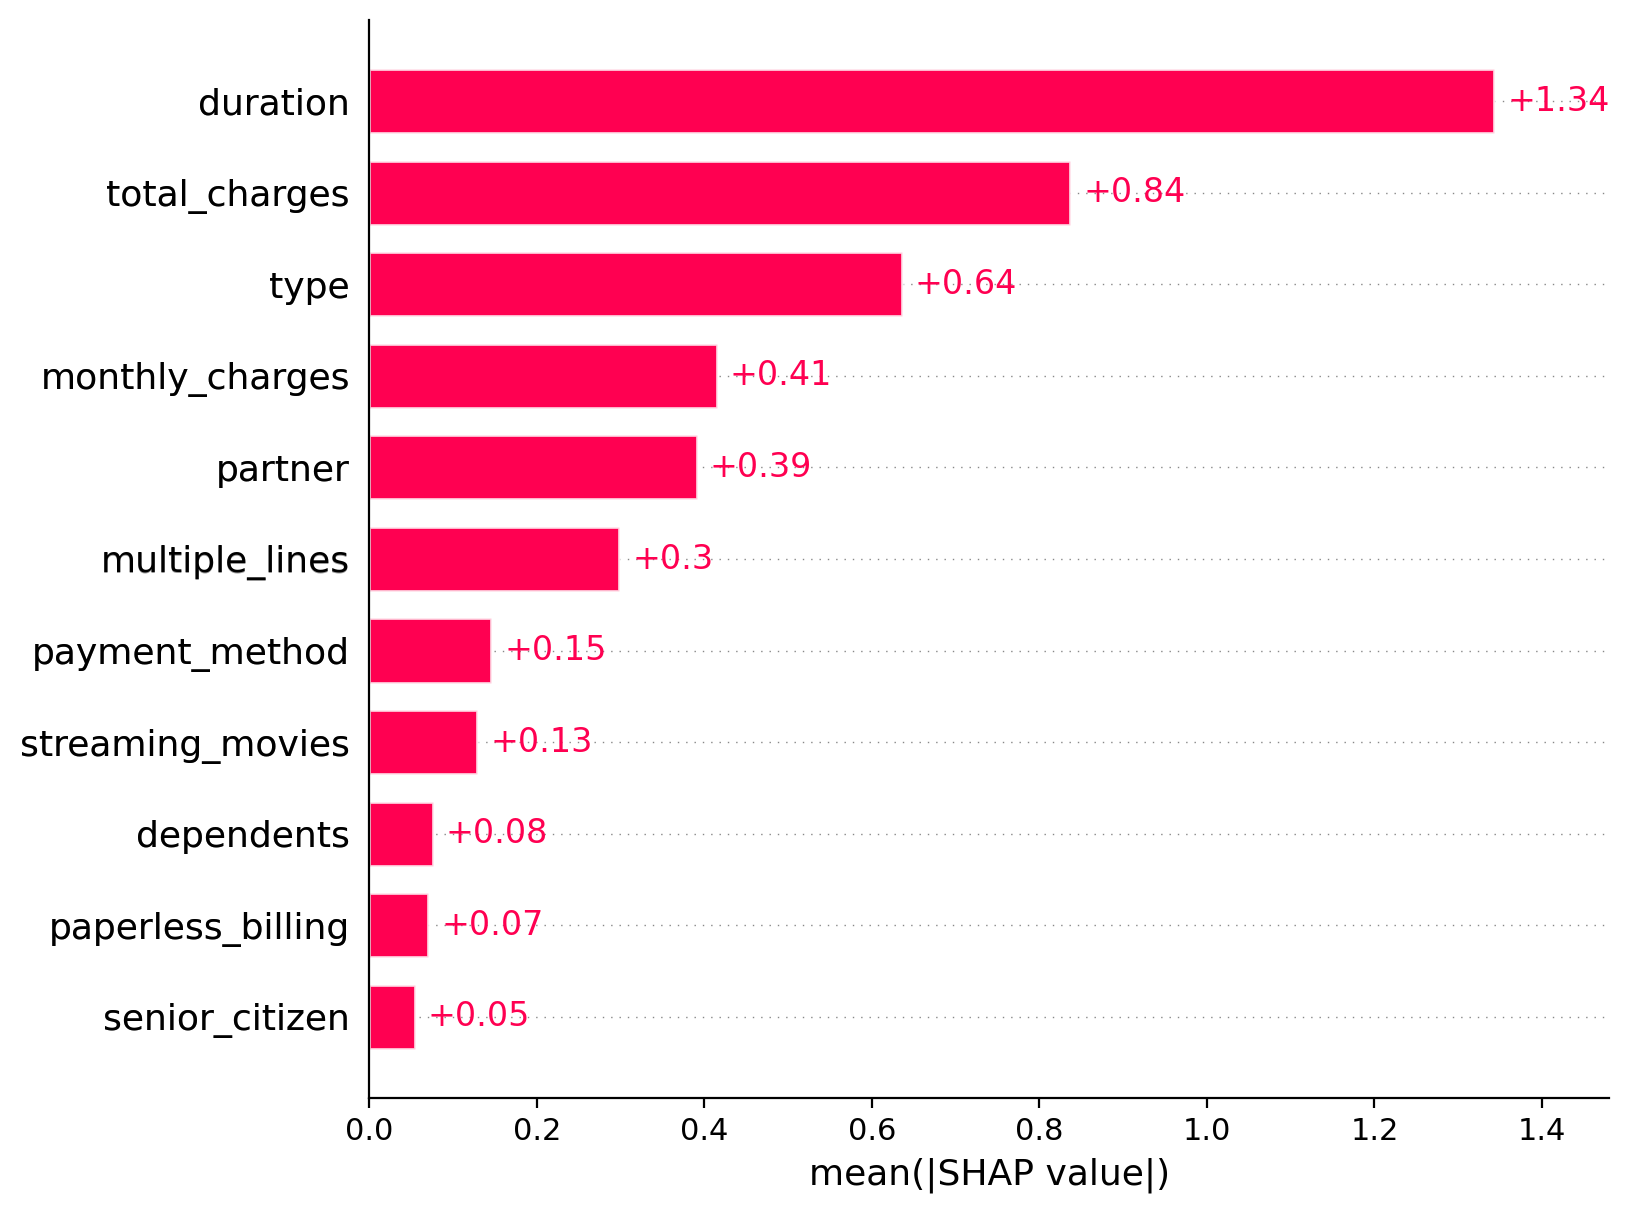

In [66]:
# построение столбчатой диаграммы средних SHAP-значений
shap.plots.bar(shap_values, max_display=20)

Из полученной диаграммы следует, что самый большой вес у признака `duration`, он сильнее всего влияет на прогнозы модели. Далее в топ-5 наиболее влияющих признаков по убыванию значимости:
- общие расходы `total_charges`,
- тип подключения `type`,
- месячные расходы `monthly_charges`,
- семейный статус `partner`.

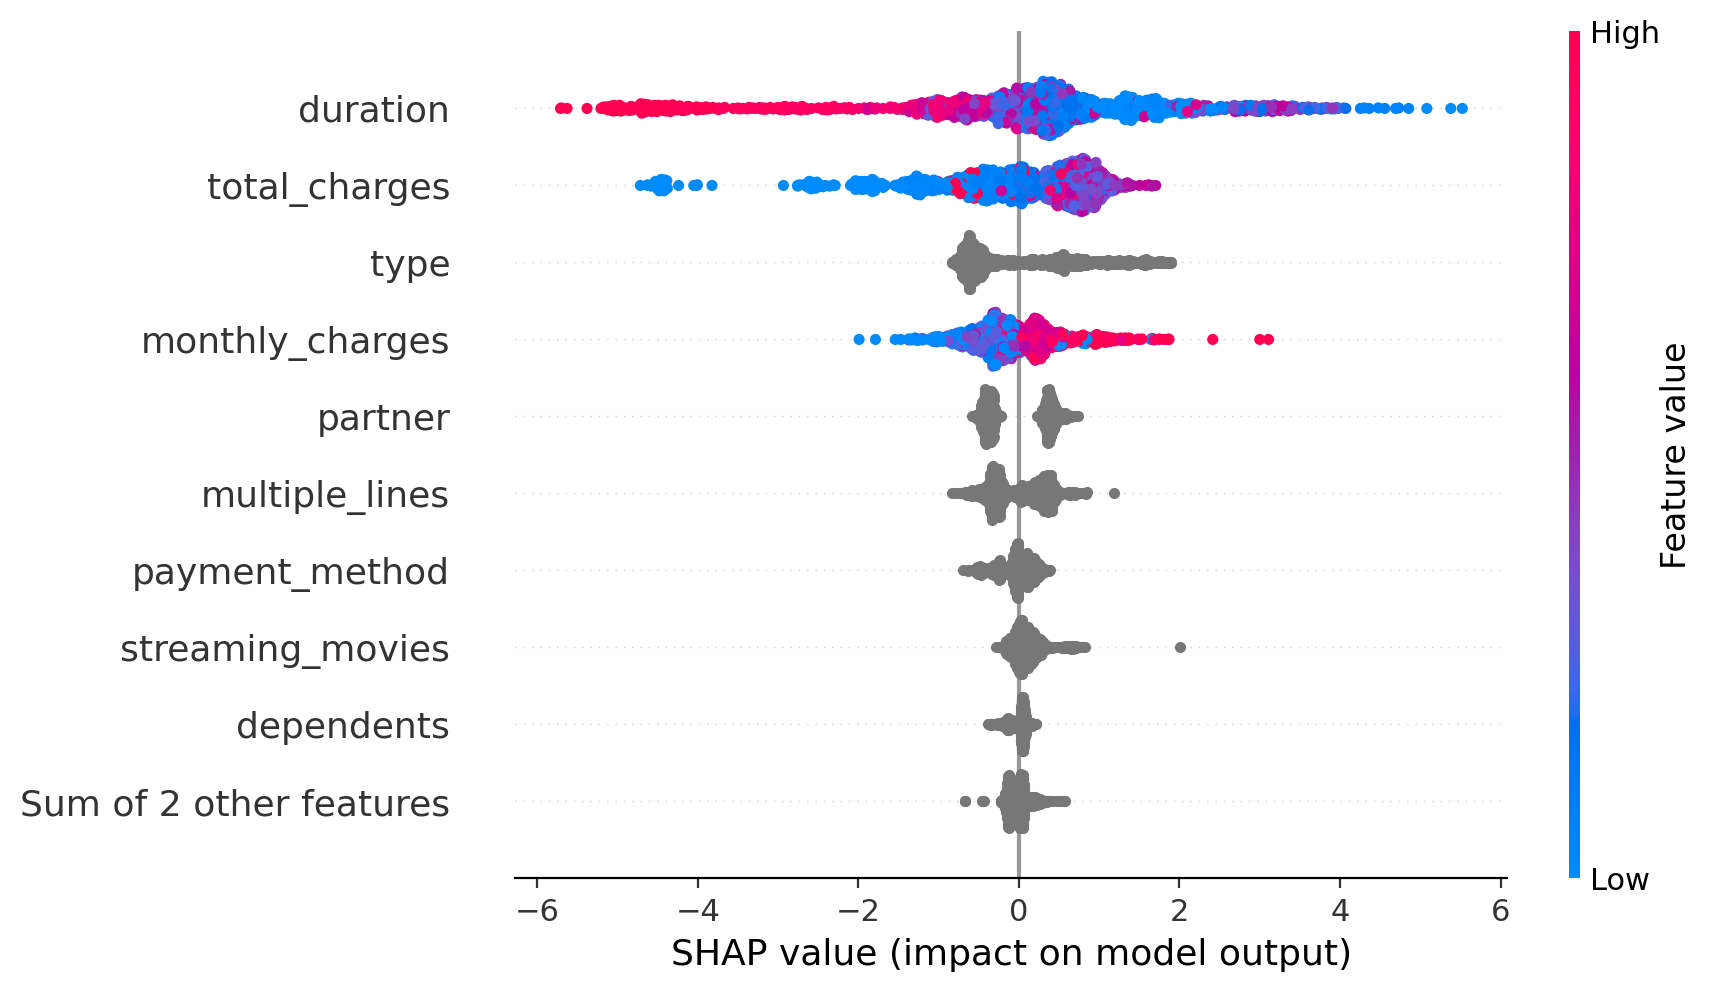

In [67]:
# построение диаграммы beeswarm
shap.plots.beeswarm(shap_values)

Согласно полученной диаграмме "beeswarm" сильный вклад оказывает количество дней, которое прошло с момента заключения договора `duration`, т.е. для клиентов, которые уже давно пользуются услугами этого провайдера, вероятность оттока ниже, чем для недавних пользователей. Хотя присутствуют также клиенты, давно оформившие договор и тем не менее затем расторгнувшие его (красные точки на отрезке SHAP value > 0).

Другим важным признаком, склоняющим модель к присвоению того или иного класса, является величина общих расходов `total_charges`. Снижение общих расходов склоняет модель к присвоению класса "0", т.е. то, что клиент не уйдет. Увеичение месячных расходов `monthly_charges`, напротив, повышает вероятность оттока.

Из категориальных признаков наибольшее влияние оказывает тип подключения `type`.

Для того, что узнать почему каждый из объектов получил класс 1 или 0, нужно визуализировать SHAP-значения с помощью диаграммы “waterfall”. К примеру для второго прогноза:

In [68]:
y_test_pred[1]

0

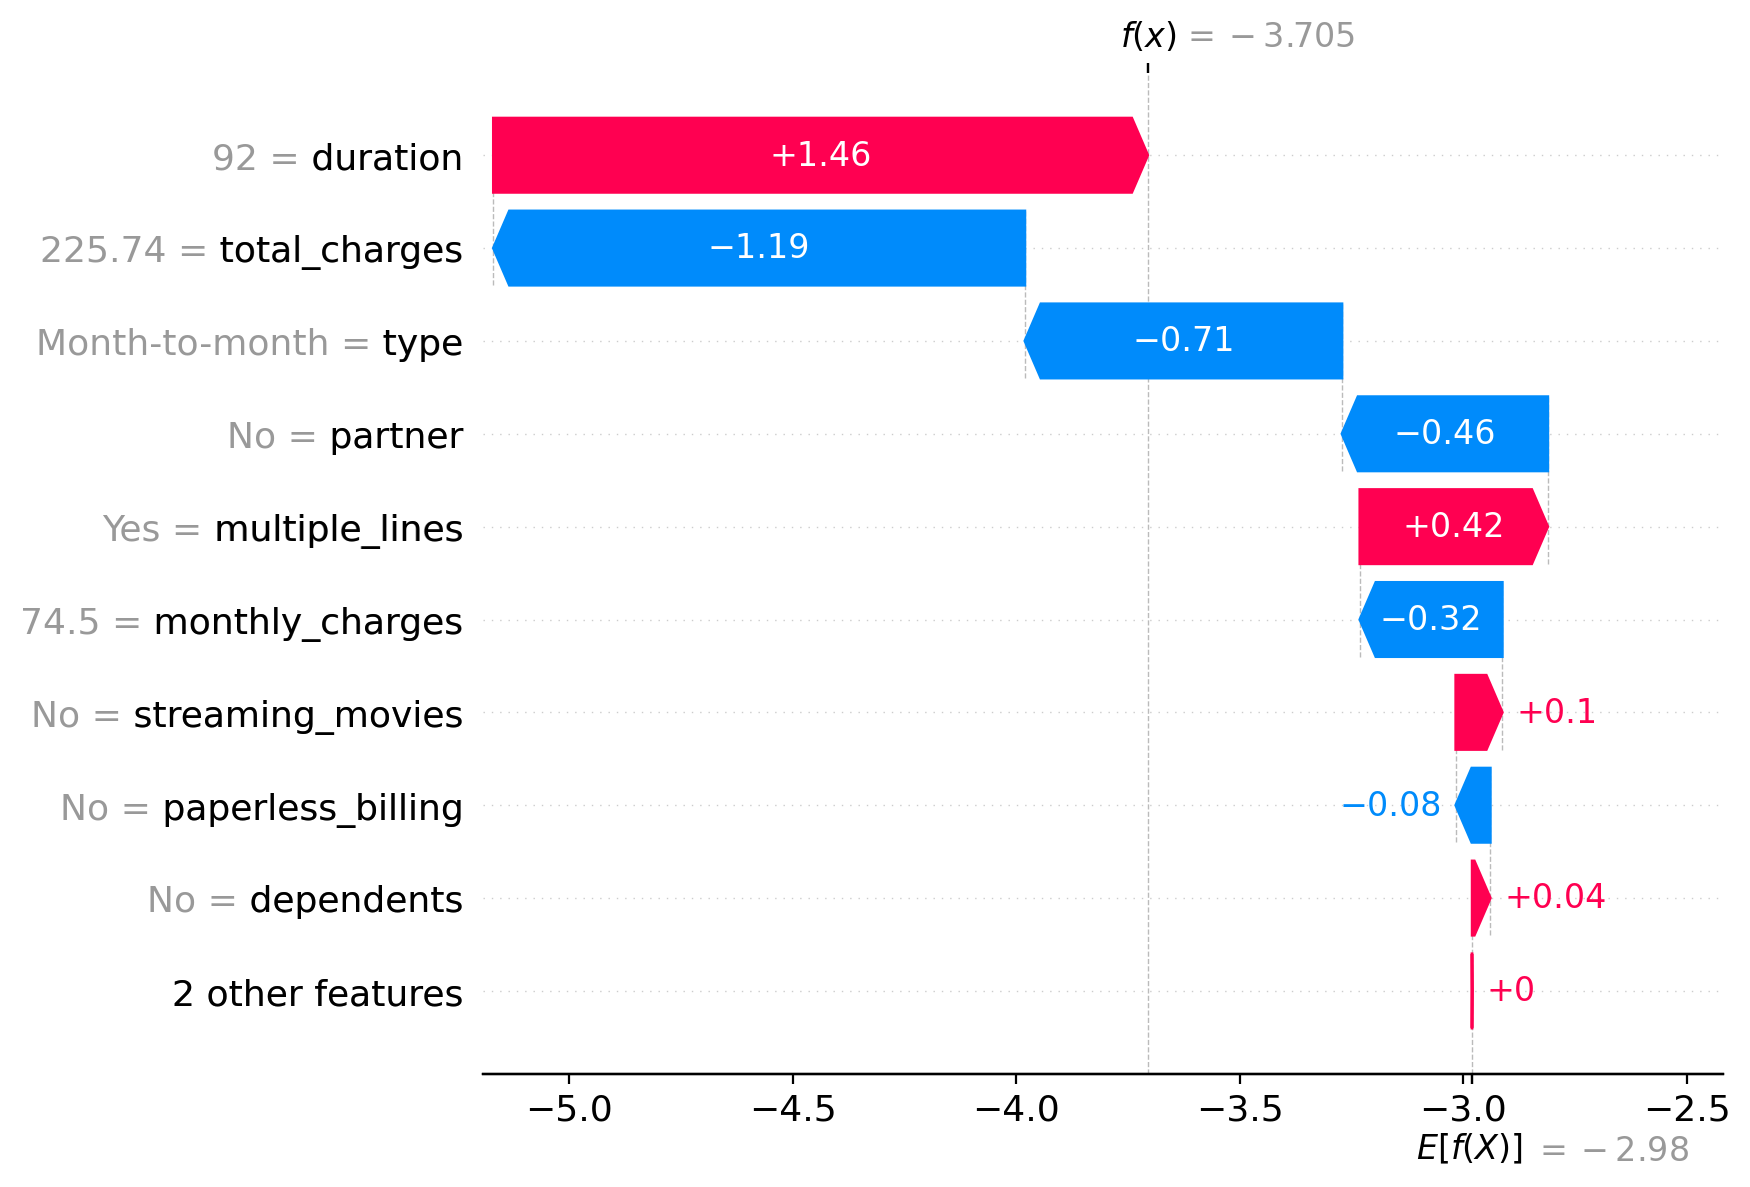

In [69]:
# построение диаграммы “waterfall” для второго объекта
shap.plots.waterfall(shap_values[1])

Модель отнесла объект к классу "0", т.к. большинство признаков указывают на то, что клиент не расторгнет договор.

### Матрица ошибок

Построим матрицу ошибок, чтобы понимать ошибки какого рода модель чаще совершает.

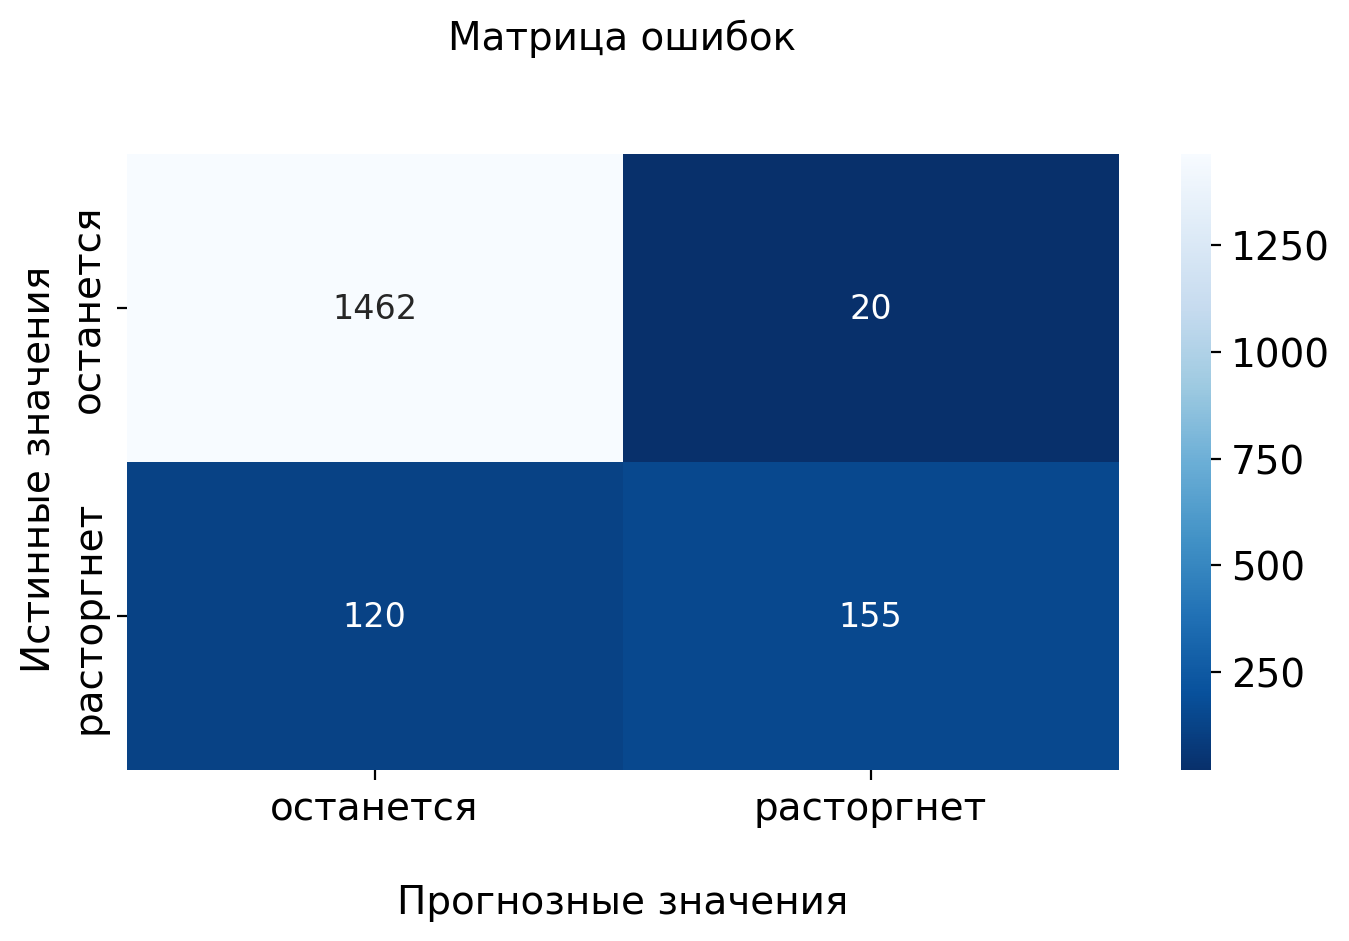

In [70]:
# расчет матрицы ошибок
cm = confusion_matrix(y_test, y_test_pred)

# визуализация матрицы ошибок с помощью тепловой карты
fig, ax = plt.subplots(figsize=(8, 4))
ax = sns.heatmap(cm, annot=True, cmap='Blues_r', annot_kws={"size":12}, fmt=".0f")

ax.set_title('Матрица ошибок\n\n');
ax.set_xlabel('\nПрогнозные значения')
ax.set_ylabel('Истинные значения ')

ax.xaxis.set_ticklabels(['останется', 'расторгнет'])
ax.yaxis.set_ticklabels(['останется', 'расторгнет'])


plt.show()

Матрица ошибок показала хороший результат: верно были предсказаны 1617 (TP+TN), а неверно 140 (FP+FN). Для 120 случаев модель выдала ложноотрицательный результат, а для 20 - ложноположительный. Таким образом, существует больший риск не предложить спецусловия клиенту, который затем уйдет, чем предложить их тому, кто не собирался уходить. такой результат мог получиться из-за несбалансированности исходных данных.

### ROC-кривая

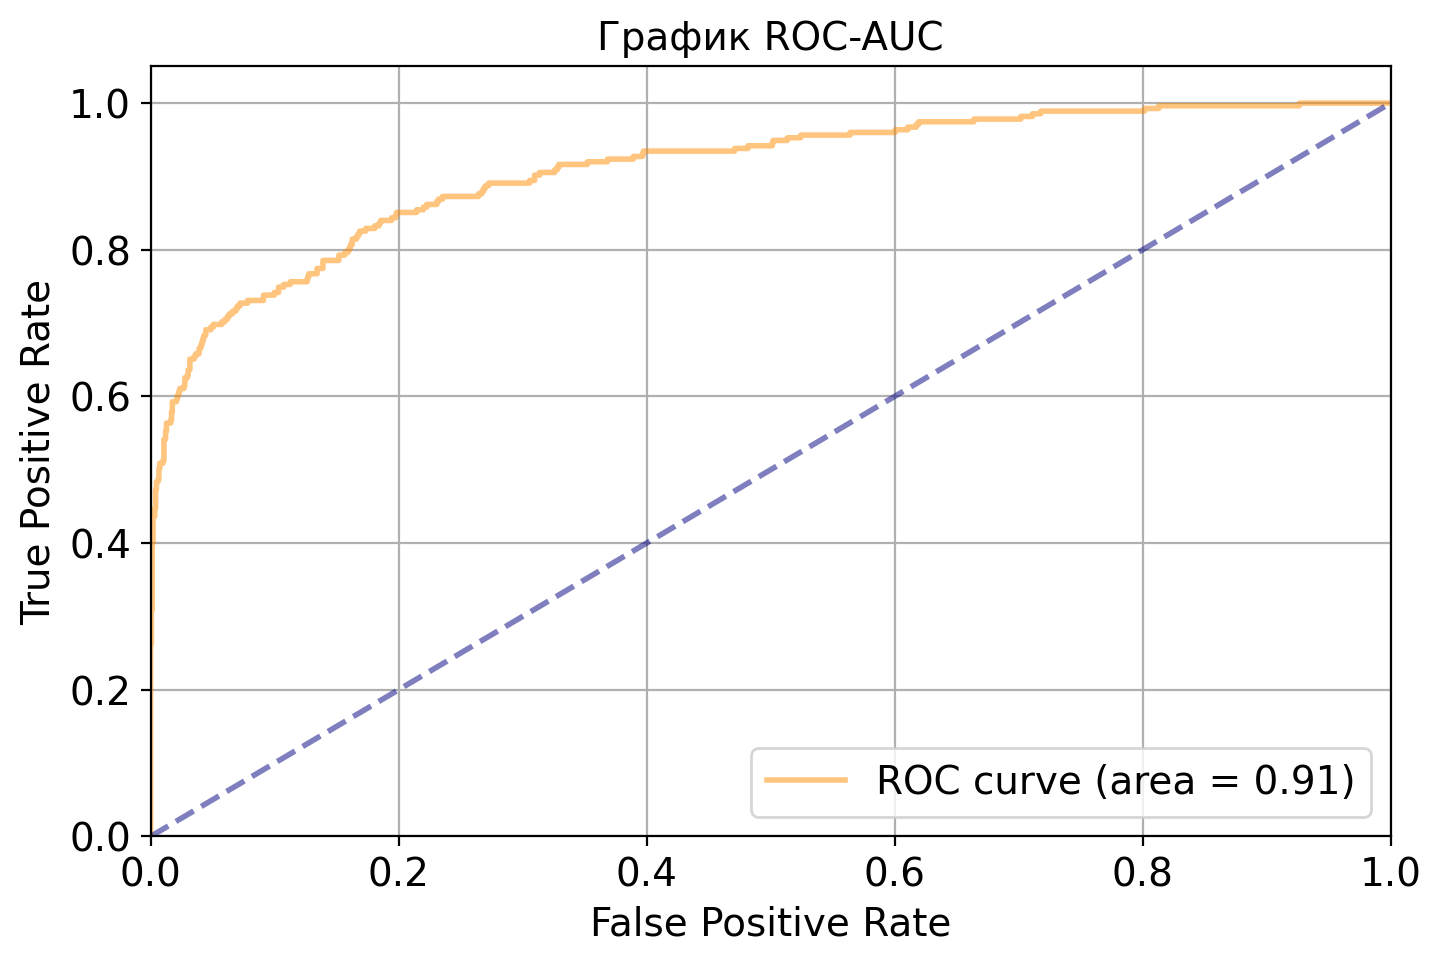

In [72]:
eval_pool = Pool(X_test, y_test, cat_features=cat_columns)
curve = get_roc_curve(model_cat, eval_pool)

(fpr, tpr, thresholds)=curve
roc_auc=sklearn.metrics.auc(fpr, tpr)

plt.figure(figsize=(8, 5))
lw=2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('График ROC-AUC')
plt.legend(loc="lower right")
plt.show()

Чем больше площадь под кривой ROC, тем лучше. По графику ROC-AUC видно, что площадь под кривой AUC модели CatBoost близка к 1.

Оценим также качество на константной Dummy модели.

In [73]:
# создание и обучение модели DummyClassifier
dummy_model = DummyClassifier(random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)

# предсказание на тестовых данных
dummy_model_preds = dummy_model.predict_proba(X_test)[:, 1]

# оценка качества dummy модели по метрике ROC-AUC
rocauc_dummy = roc_auc_score(y_test, dummy_model_preds)
print(f'Метрика ROC-AUC на тестовой выборке дамми-модели: {round(rocauc_dummy, 3)}')

Метрика ROC-AUC на тестовой выборке дамми-модели: 0.5


Метрика ROC-AUC на дамми модели оказалась существенно хуже всех обученных моделей.

## Общий вывод:

В ходе данного проекта были изучены данные по клиентам оператора связи "ТелеДом".

Перед проведением анализа и моделирования была сделана <u>предобработка данных</u>, в ходе которой были выявлены следующие моменты и проведены следующие действия:
- После объединения датафреймов появились пропуски в 8 столбцах. Они были заполнены значением 'Not used'.
- Обнаружены неявные пропуски в столбце `total_charges`. Их оказалось 0.16% от общего объема данных в этом столбце. Эти строки с пробелами были удалены.
- Названия столбцов приведены к "змеиному" регистру.
- Были обнаружены 4 строчки с явными дубликатами. Они были удалены.
- Неявных дубликатов нет.
- Были преобразованы типы данных в столбцах `total_charges`, `begin_date` и `end_date`.

На этапе <u>исследовательского анализа данных</u>:
- созданы новые признаки: целевой `quit`, длительность контракта в днях `duration`, количество новых и ушедших пользователей `num_new_clients` и `num_quit_clients`
- выявлен дисбаланс классов в целевом признаке: действующих абонентов (класс "0") в 5.4 раз больше, чем ушедших (класс "1")
- изучено распределение и описательные статистики всех количественных признаков.
- построены столбчатые диаграммы для всех категориальных признаков для понимания распределения различных классов данных в датасете
- проанализировано изменение количества новых и ушедших пользователей со временем. В целом наблюдается положительный прирост: количество новых клиентов превышает количество ушедших в среднем на 200 человек.

В ходе <u>корреляционного анализа данных</u> были расчитана матрица корреляции коэффициентов Фи. Было выявлено, что мультиколлинеарность между признаками (от 94 до 97%), относящимися к интернет-услугам: **internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies**. Для моделирования оставили из них один признак streaming_movies, а остальные удалили. Также удалили признак **gender**, т.к. у него практически нулевая взаимосвязь со всеми признаками.

На этапе <u>обучения модели</u> было построено 3 модели: LogisticRegression, CatBoostClassifier, SGDClassifier. Для обучения использовались 8 входных признаков: 'type', 'paperless_billing', 'payment_method', 'senior_citizen',    'partner', 'dependents', 'streaming_movies', 'multiple_lines'.
По результатам кросс-валидации лучшей оказалась модель CatBoostClassifier с параметрами {'depth': 4, 'learning_rate': 0.1, 'l2_leaf_reg': 3}. Ее метрика ROC-AUC на кросс-валидации равна 91%. Метрика ROC-AUC на тестовых данных оказалась чуть ниже, чем на кросс-валидации - 90.9%

Затем был сделан <u>анализ важности</u> признаков с помощью SHAP-значений.
Топ-5 наиболее значимых признаков:
- длительность контракта в днях `duration`,
- общие расходы `total_charges`,
- тип подключения `type`,
- месячные расходы `monthly_charges`,
- семейный статус `partner`.

<u>Матрица ошибок</u> показала хороший результат: верно были предсказаны 1617 (TP+TN), а неверно 140 (FP+FN). Для 120 случаев модель выдала ложноотрицательный результат, а для 20 - ложноположительный. Таким образом, существует больший риск не предложить спецусловия клиенту, который затем уйдет, чем предложить их тому, кто не собирался уходить.

Анализ кривой ROC-AUC также показал лучшее качество модели CatBoost по сравнению с другими.

Рекомендации:

- Протестировать различные техники для снижения дисбаланса классов, чтобы уменьшить количество ложноотрицательных прогнозов модели.